## Análisis de tarifas prepago - Megaline

Tenemos los datos para analizar dos tarifas prepago que ofrece la empresa: Surf y Ultimate.

Nuestro objetivo será investigar el comportamiento de cada uno para determinar cuál plan genera más ingresos para así ajustar el presupuesto de publicidad.

Realizaremos un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña.

Tendremos los datos de 500 clientes de Megaline. Esta información contiene:
 - Quiénes son los clientes
 - De dónde son
 - Qúe tarifa usan
 - Cantidad de llamadas que hicieron
 - Mensajes de texto
 
*Nota: Los datos corresponden al año 2018.*

Nuestro informe tendrá la siguiente estructura:


***Tabla de contenidos***

2.    Inicialización 
      - Carga de datos
      - Exploración de datos iniciales    
3.    Preprocesamiento de datos
      - Valores ausentes
      - Duplicados
4.    Enriquecimiento de datos
5.    Análisis de datos
      - Clientes de plan Surf
      - Clientes de plan Ultimate     
6.    Pruebas de hipótesis
      - Primera hipótesis
      - Segunda hipótesis    
7.    Conclusiones

## Inicialización

Cargamos las librerías necesarias para el análisis de datos.

In [1]:
# Cargamos las librerías
import pandas as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Cargamos opciones de visualización
pd.options.display.max_columns = None

### Carga de datos

Cargamos los conjuntos de datos y le asignamos un dataframe a cada uno.

In [3]:
# Creamos dataframe con los datos
calls_data = pd.read_csv('/datasets/megaline_calls.csv')
internet_data = pd.read_csv('/datasets/megaline_internet.csv')
messages_data = pd.read_csv('/datasets/megaline_messages.csv')
plans_data = pd.read_csv('/datasets/megaline_plans.csv')
users_data = pd.read_csv('/datasets/megaline_users.csv')

### Exploración de datos iniciales

#### calls_data

In [4]:
# Información de datos de llamadas
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


La tabla calls (datos sobre las llamadas):
- id — identificador único de la llamada
- call_date — fecha de la llamada
- duration — duración de la llamada (en minutos)
- user_id — el identificador del usuario que realiza la llamada

#### internet_data

In [5]:
# Información de datos de internet
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


La tabla internet (datos sobre las sesiones web):
- id — identificador único de la sesión
- mb_used — el volumen de datos gastados durante la sesión (en megabytes)
- session_date — fecha de la sesión web
- user_id — identificador del usuario


#### messages_data

In [6]:
# Información de datos de mensajes
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


La tabla messages (datos sobre los SMS):
- id — identificador único del SMS
- message_date — fecha del SMS
- user_id — el identificador del usuario que manda el SMS

#### plans_data

In [7]:
# Información de datos de los planes
plans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


La tabla plans (datos sobre las tarifas):
- plan_name — nombre de la tarifa
- usd_monthly_fee — pago mensual en dólares estadounidenses
- minutes_included — minutos incluidos al mes
- messages_included — SMS incluidos al mes
- mb_per_month_included — datos incluidos al mes (en megabytes)
- usd_per_minute — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)
- usd_per_message — precio por SMS tras exceder los límites del paquete
- usd_per_gb — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)


**Descripción de las tarifas:**

*Llamadas:*
- Cada llamada individual se redondea, incluso si la llamada duró solo un segundo, se contará como un minuto.

*Tráfico web:*
- El total del mes se redondea hacia arriba. Ejemplo: Si alguien usa 1025mb, se cobrará 2gb.

*Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes.*

**Plan Surf:**
1. Pago mensual: 20\$ 
2. 500 minutos al mes, 50 SMS, 15gb de datos.
3. Si se exceden los límites del paquete:
  - 1 minuto: 3 centavos
  - 1 SMS: 3 centavos
  - 1 gb de datos: 10\$
  
**Plan Ultimate:**
1. Pago mensual: 70\$
2. 3000 minutos al mes, 1000 SMS, 30gb de datos.
3. Si se exceden los límites del paquete:
  - 1 minuto: 1 centavo
  - 1 SMS: 1 centavo
  - 1 gb de datos: 7\$

#### users_data

In [8]:
# Información de datos de los usuarios
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


La tabla users (datos sobre los usuarios):
- user_id — identificador único del usuario
- first_name — nombre del usuario
- last_name — apellido del usuario
- age — edad del usuario (en años)
- reg_date — fecha de suscripción (dd, mm, aa)
- churn_date — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
- city — ciudad de residencia del usuario
- plan — nombre de la tarifa

### Resumen de datos iniciales

**Información de llamadas: calls_data**
- Total de 137735 registros en 4 columnas: id, user_id, call_date y duration.
- No hay valores ausentes.
- Tipo de datos de columna call_date puede ser modificada de tipo object a datetime.

**Información de datos de internet: internet_data**
- Total de  104825 registros en 4 columnas: id, user_id, session_date y mb_used.
- No hay valores ausentes.
- Tipo de datos de columna session_date puede ser modificada de tipo object a datetime.

**Información de datos de mensajes: messages_data**
- Total de 76051 registros en 3 columnas: id, user_id y message_date.
- No hay valores ausentes.
- Tipo de datos de columna message_date puede ser modificada de tipo object a datetime.

**Información de los datos de planes: plans_data**
- Total de 2 registros con 8 columnas, las que contienen la información para cada plan descrito anteriormente.
- No hay valores ausentes.

**Información de los datos de usuarios: users_data**
- Total de 500 registros en 8 columnas: user_id, first_name, last_name, age, city, reg_date, plan y churn_date.
- Existen valores ausentes en churn_date.
- Tipo de datos de columna reg_date puede ser modificada de tipo object a datetime.

### Conclusiones preliminares respecto a los datos en bruto

Tenemos 5 tablas de datos de las cuales 4 están relacionadas mediante la columna "user_id". Existen tres grupos de datos distintos:
 - 1. Tabla con datos de los 500 usuarios.
 - 2. Tablas con información de uso (llamadas, internet y mensajes). Cada una de estas presenta información independiente.
 - 3. Tabla con información básica de los planes prepago.
 
Estas últimas 4 columnas mencionadas presentan datos de fechas las cuales podemos convertir a tipo datetime, con el fin de obtener información valiosa sobre los usos o periodos de contratación más exitosos.


***Caso de valores ausentes en users_data / churn_date :***

Churn_date corresponde a la fecha en que usuarios dejaron de usar el servicio. Tenemos solo 34 usuarios con esta condición. 
Los datos de esta columna nos sirven para calcular el tiempo que han mantenido los usuarios con algún plan; por esta razón, los valores ausentes serán reemplazados con la fecha en la que se recopilaron los datos ya que correspondería al tiempo que llevan los usuarios que siguen vigentes.

Adicional a estas modificaciones, analizaremos las 4 tablas principales en busca de duplicados; observaremos la información de duración de llamadas y megabytes usados para ver si comprenden intervalos normales; y por último, enriqueceremos los datos a través de nuevas columnas con información que simplificará nuestro análisis.

## Preprocesamiento de datos

### Valores ausentes en churn_date

Procedemos a completar los valores ausentes con la fecha en que se recolectaron los datos. Como los datos corresponden al año 2018, fijaremos la fecha final en el 1 de enero del 2019. Primero, observamos la estructura de datos:

In [9]:
# Mostramos algunos datos para ver su estructura
users_data['churn_date'].value_counts().head()

2018-12-18    3
2018-12-31    2
2018-11-14    2
2018-12-19    2
2018-12-26    1
Name: churn_date, dtype: int64

In [10]:
# Completamos los valores ausentes con la fecha establecida
users_data['churn_date'] = users_data['churn_date'].fillna('2019-01-01')

Ahora, cambiamos el tipo de datos a datetime.

In [11]:
# Aplicamos formato datetime
users_data['churn_date']= pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')

In [12]:
# Comprobamos el tipo de datos
users_data['churn_date'].dtype

dtype('<M8[ns]')

In [13]:
# Vemos como queda la tabla de usuarios
users_data.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,2019-01-01
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,2019-01-01
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-01
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-01


Ya hemos completado los datos ausentes. Debemos recordar que consideramos la fecha 1 de enero del 2019 solo para efectos de análisis, teniendo claro que los datos corresponden al intervalo del año 2018.

### Comprobación de duplicados

Comprobamos los duplicados en las 4 tablas principales que contienen mayor cantidad de datos.

In [14]:
# Comprobación de duplicados en calls_data
calls_data.duplicated().sum()

0

In [15]:
# Comprobación de duplicados en internet_data
internet_data.duplicated().sum()

0

In [16]:
# Comprobación de duplicados en messages_data
messages_data.duplicated().sum()

0

In [17]:
# Comprobación de duplicados en users_data
users_data.duplicated().sum()

0

Comprobación lista, no tenemos registros duplicados.

### Comprobación de información en llamadas e internet

Precisamente analizaremos las columnas de **duration** en el caso de las llamadas y **mb_used** en el caso de internet. Analizaremos sus mínimos y máximos para ver si corresponden a valores razonables.

In [18]:
calls_data['duration'].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

*Nota: La duración de las llamadas se presenta en minutos*

Contamos con llamadas de 0 minutos. Puede tratarse de llamadas perdidas o llamadas que nunca lograron establecer comunicación. Recordemos que Megaline redondea al minuto si es que cuenta al menos 1 segundo; por lo tanto, estos datos con minuto 0 pueden entorpecer nuestro análisis que se debiera basar en el consumo real. Estos registros con llamadas de 0 minutos solo agrandan la muestra y no logran tener una relevancia en el cobro de los planes. Veremos qué porción de los datos constituye para simplemente eliminar estos registros.

In [19]:
# Asignamos una variable al número total de llamadas con tiempo 0
zero_min_calls = calls_data.query('duration == 0')['duration'].count()
# Calculamos la porción del total
zero_min_calls / len(calls_data)

0.1948233927469416

Las llamadas con una duración de 0 minutos corresponden al 20% aproximadamente de los registros.
Es una porción bastante importante pero debemos tener claro los objetivos principales: estudiar el comportamiento de los clientes y determinar qué plan de prepago genera más ingresos.

Eliminaremos las llamadas de 0 minutos por las siguientes razones:
 - No afectan el cobro ya que no se contabiliza el tiempo.
 - No tenemos claridad del por qué los registros tienen 0 minutos. Pueden ser llamadas perdidas, errores, etc.
 - Sus datos solo afectarían a la cantidad de llamadas hechas pero ni siquiera sabemos si realmente corresponden a llamadas emitidas.
 
*Nota: Crearemos un nuevo dataframe sin las llamadas de 0 minutos y tendremos que ir actualizándolo si realizamos cambios posteriores a calls_data.*

In [20]:
# Creamos un dataframe limpio sin llas llamadas de 0 minutos
calls_data_clean = calls_data.query('duration != 0')

In [21]:
# Comprobamos las duraciones de llamada y la nueva cantidad de datos
calls_data_clean['duration'].describe()

count    110901.000000
mean          8.378196
std           5.354567
min           0.010000
25%           4.150000
50%           7.710000
75%          11.820000
max          37.600000
Name: duration, dtype: float64

Listo, ya hemos disminuído nuestro conjunto de datos en un 20%. 

Ahora, analizaremos la columna mb_used en la tabla de internet:

In [22]:
# Valores estadísticos de mb_used
internet_data['mb_used'].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

En el caso de los megabytes usados, el valor máximo y mínimo presentan rangos normales para esta característica. 
Si bien el valor mínimo es 0, a diferencia de la duración de llamadas, para los datos se realiza una totalización mensual la cual se redondea hacia arriba para calcular el precio total.

## Enriquecimiento de datos

### Transformación de fechas

La primera medida que tomaremos será transformar a tipo datetime las fechas  de las 3 tablas con información de uso (llamadas, internet y mensajes). La cuarta, con la información de los usuarios, necesita un cambio a datetime en la fecha de registro del usuario (reg_date).

In [23]:
# Mostramos algunas fechas de llamadas para ver su estructura
calls_data['call_date'].value_counts().head()

2018-12-27    1091
2018-12-28    1085
2018-12-30    1080
2018-12-24    1078
2018-12-29    1070
Name: call_date, dtype: int64

In [24]:
# Mostramos algunas fechas de sesiones de internet para ver su estructura
internet_data['session_date'].value_counts().head()

2018-12-24    851
2018-12-30    845
2018-12-27    830
2018-12-21    826
2018-12-31    823
Name: session_date, dtype: int64

In [25]:
# Mostramos algunas fechas de mensajes para ver su estructura
messages_data['message_date'].value_counts().head()

2018-12-28    702
2018-12-27    701
2018-12-25    699
2018-12-31    699
2018-12-18    688
Name: message_date, dtype: int64

In [26]:
# Mostramos algunas fechas de mensajes para ver su estructura
users_data['reg_date'].value_counts().head()

2018-03-08    5
2018-07-12    5
2018-06-04    5
2018-08-03    5
2018-02-06    5
Name: reg_date, dtype: int64

Las fechas para las cuatro tablas presentan la misma estructura: año, mes y día.
Procedemos a realizar la transformación:

In [27]:
# Aplicamos formato datetime a los 3 grupós de datos
calls_data['call_date']= pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
internet_data['session_date']= pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
messages_data['message_date']= pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')

### Redondeo duración de llamadas

Teniendo en cuenta los redondeos de Megaline para calcular las tarifas, crearemos una nueva columna donde tendremos los valores redondeados. Esta columna la usaremos en análisis relacionados a ingresos para la empresa.

Los redondeos que aplicaremos son los siguientes:
 - La duración de llamadas se redondeará hacia arriba ya que las fracciones de segundo se consideran como minuto.
 
*Nota: Los megabytes usados solo son redondeados cuando se totaliza el mes. Por lo tanto, más adelante nos encargaremos de esto.*

In [28]:
# Creamos una nueva columna con la duración de llamadas redondeada hacia arriba
calls_data['rounded_duration'] = np.ceil(calls_data['duration'])
# Cambiamos los datos de la nueva columna a tipo entero
calls_data['rounded_duration'] = calls_data['rounded_duration'].astype('int')
# Vemos como queda la nueva columna
calls_data.head()

,id,user_id,call_date,duration,rounded_duration
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5


Ya tenemos los minutos redondeados.

### Columnas para agrupación mensual

Crearemos una columna en cada tabla que detallará el mes para las llamadas, sesión de internet y mensajes.

In [29]:
# Columna de mes para calls_data
calls_data['call_month'] = calls_data['call_date'].dt.month
# Columna de mes para internet_data
internet_data['session_month'] = internet_data['session_date'].dt.month
# Columna de mes para messages_data
messages_data['message_month'] = messages_data['message_date'].dt.month

In [30]:
# Comprobamos una tabla
internet_data.head(10)

,id,user_id,session_date,mb_used,session_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
5,1001_0,1001,2018-08-24,284.68,8
6,1001_3,1001,2018-12-09,656.04,12
7,1001_4,1001,2018-11-04,16.97,11
8,1001_10,1001,2018-11-27,135.18,11
9,1001_15,1001,2018-12-13,761.92,12


Listo, ya tenemos columnas de meses para cada tabla.

### Columna de tiempo de servicio en users_data

Añadiremos una columna a nuestra tabla users_data, en la que mostraremos la cantidad de meses (cumplidos) de contrato de servicio. Para esto usaremos la fecha de reg_date con churn_date.

In [31]:
# Creamos una columna de tiempo activo por usuarios. El tiempo se mostrará en meses.
users_data['active_time'] = (users_data['churn_date'] - users_data['reg_date']) / np.timedelta64(1, 'M')

In [32]:
# Mostramos como queda la tabla
users_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,active_time
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,0.262839
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,4.632539
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,2.365552
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,11.104951
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,7.326639


Considerando que usaremos la información del tiempo activo como cliente para determinar las ventas, debemos tener en cuenta que se tratan de servicios **prepago**, por lo tanto redondearemos el tiempo de los meses hacia arriba por considerar las fracciones de meses como meses "ya pagados".

In [33]:
# Redondeamos hacia arriba la nueva columna
users_data['active_time'] = users_data['active_time'].apply(np.ceil)
# Cambiamos los datos de la nueva columna a tipo entero
users_data['active_time'] = users_data['active_time'].astype('int')
# Vemos nuevamente como queda
users_data.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,active_time
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,1
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,5
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,3
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,12
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,8
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,2019-01-01,2
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,2019-01-01,6
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-01,5
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-01,9


Listo, ya tenemos el tiempo activo de cada usuario con el que podremos determinar fácilmente el pago mensual.

### Pago fijo mensual por usuario

Para calcular el costo fijo de cada usuario según el plan, crearemos una función que calculará el valor en base al tipo de plan y tiempo activo.

In [34]:
# Creamos una función para el costo fijo.

def user_fixed_costs(row):
    plan = row['plan']
    active_time = row['active_time']
                
    ultimate = 70
    surf = 20
    
    if plan == 'ultimate':
        fixedcosts = ultimate * active_time
        return fixedcosts
    elif plan == 'surf':
        fixedcosts = surf * active_time
        return fixedcosts
        

In [35]:
# Creamos una nueva columna para aplicar la función que creamos
users_data['fixed_costs'] = users_data.apply(user_fixed_costs, axis=1)

In [36]:
# Mostramos como queda la tabla con el cálculo de costos fijos para cada usuario
users_data.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,active_time,fixed_costs
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,1,70
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,5,100
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,3,60
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,12,240
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,8,160
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,2019-01-01,2,40
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,1,70
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,2019-01-01,6,120
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2019-01-01,5,350
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2019-01-01,9,180


Ahora sería bueno agregar una columna que calcule los costos variables para cada usuario, pero antes de eso, necesitamos trabajar con las otras tablas (información de llamadas, internet y mensajes).

### Llamadas por usuario

Primero investigaremos la cantidad y minutos usados en las llamadas. Para eso crearemos tablas dinámicas en las que agruparemos los usuarios.

Actualizaremos nuestro registro de llamadas para eliminar todas las que tienen una duración de 0 minutos (lo que desarrollamos previamente).

In [37]:
# Actualizamos el dataframe limpio sin llas llamadas de 0 minutos
calls_data_clean = calls_data.query('duration != 0')
len(calls_data) - len(calls_data_clean)

26834

Eliminamos 26834 registros de llamadas con un tiempo de 0 minutos.

In [38]:
# Mostramos la estructura de los datos de llamadas
calls_data_clean.head()

,id,user_id,call_date,duration,rounded_duration,call_month
0,1000_93,1000,2018-12-27,8.52,9,12
1,1000_145,1000,2018-12-27,13.66,14,12
2,1000_247,1000,2018-12-27,14.48,15,12
3,1000_309,1000,2018-12-28,5.76,6,12
4,1000_380,1000,2018-12-30,4.22,5,12


Creamos una tabla dinámica agrupando los datos por user_id:

In [39]:
# Agrupamos a los usuarios mediante una tabla dinámica en la que contamos llamadas y sumamos minutos
calls_pivot = calls_data_clean.pivot_table(
    index='user_id', columns= 'call_month', values='rounded_duration', aggfunc=['count', 'sum']
)

# Completamos los valores ausentes con el valor 0
calls_pivot = calls_pivot.fillna(0)

# Reseteamos el índice de la tabla dinámica y pasamos user_id como columna
calls_pivot['user_id'] = calls_pivot.index
calls_pivot = calls_pivot.reset_index(drop=True)

# Cambiamos el nombre de las columnas
calls_pivot.columns = [
    'Jan_calls','Feb_calls','Mar_calls',
    'Apr_calls','May_calls','Jun_calls',
    'Jul_calls','Aug_calls','Sep_calls',
    'Oct_calls','Nov_calls','Dec_calls',
    'Jan_time','Feb_time','Mar_time',
    'Apr_time','May_time','Jun_time',
    'Jul_time','Aug_time','Sep_time',
    'Oct_time','Nov_time','Dec_time',
    'user_id']

# Creamos una columna con la suma de la cantidad de llamadas
calls_pivot['total_calls'] = calls_pivot[[
    'Jan_calls','Feb_calls','Mar_calls',
    'Apr_calls','May_calls','Jun_calls',
    'Jul_calls','Aug_calls','Sep_calls',
    'Oct_calls','Nov_calls','Dec_calls'
]].sum(axis=1)

# Creamos una columna con la suma de las duraciones de las llamadas
calls_pivot['total_time'] = calls_pivot[[
    'Jan_time','Feb_time','Mar_time',
    'Apr_time','May_time','Jun_time',
    'Jul_time','Aug_time','Sep_time',
    'Oct_time','Nov_time','Dec_time'
]].sum(axis=1)

# Cambiamos user_id a la primera posición
first_calls_pivot = calls_pivot.pop('user_id')
calls_pivot.insert(0, 'user_id', first_calls_pivot)

# Transformamos la tabla a datos de número entero
calls_pivot = calls_pivot.astype('int')

# Mostramos como queda la tabla
calls_pivot

,user_id,Jan_calls,Feb_calls,Mar_calls,Apr_calls,May_calls,Jun_calls,Jul_calls,Aug_calls,Sep_calls,Oct_calls,Nov_calls,Dec_calls,Jan_time,Feb_time,Mar_time,Apr_time,May_time,Jun_time,Jul_time,Aug_time,Sep_time,Oct_time,Nov_time,Dec_time,total_calls,total_time
0,1000,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,124,16,124
1,1001,0,0,0,0,0,0,0,22,38,47,49,46,0,0,0,0,0,0,0,182,315,393,426,412,202,1728
2,1002,0,0,0,0,0,0,0,0,0,8,48,38,0,0,0,0,0,0,0,0,0,59,386,384,94,829
3,1003,0,0,0,0,0,0,0,0,0,0,0,118,0,0,0,0,0,0,0,0,0,0,0,1104,118,1104
4,1004,0,0,0,0,19,33,45,42,32,47,45,43,0,0,0,0,193,275,381,354,301,365,476,427,306,2772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,1495,0,0,0,0,0,0,0,0,37,65,50,56,0,0,0,0,0,0,0,0,302,610,361,492,208,1765
477,1496,0,0,0,0,0,0,0,14,45,35,32,32,0,0,0,0,0,0,0,122,414,317,308,294,158,1455
478,1497,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,300,42,300
479,1498,0,28,29,42,29,29,40,37,39,37,29,32,0,244,266,365,288,238,321,266,363,298,223,339,371,3211


Ya tenemos el resumen de los totales de llamadas para cada usuario. Ahora lo realizaremos con los datos de internet.

### Uso de internet por usuario

Primero, debemos redondear los valores de megabytes usados. Recordemos que Megaline aproxima los mb a gb; por lo tanto, luego de sumar los valores por usuario, crearemos una columna con el valor apropiado en gigabytes para cada usuario (aproximando hacia arriba).

In [40]:
# Mostramos la estructura de los datos de internet_data
internet_data.head()

,id,user_id,session_date,mb_used,session_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [41]:
# Agrupamos a los usuarios mediante una tabla dinámica en la que sumamos sus megabytes
internet_pivot = internet_data.pivot_table(index='user_id', columns='session_month', values='mb_used', aggfunc='sum')

# Completamos los valores ausentes con el valor 0
internet_pivot = internet_pivot.fillna(0)

# Reseteamos el índice de la tabla dinámica y pasamos user_id como columna
internet_pivot['user_id'] = internet_pivot.index
internet_pivot = internet_pivot.reset_index(drop=True)

# Cambiamos el nombre de las columnas
internet_pivot.columns = ['Jan_gb','Feb_gb','Mar_gb','Apr_gb','May_gb','Jun_gb',
                          'Jul_gb','Aug_gb','Sep_gb','Oct_gb','Nov_gb','Dec_gb',
                          'user_id']
internet_pivot = internet_pivot.astype('int')

# Creamos una columna con la suma de todos los meses
internet_pivot['gb_totals'] = internet_pivot.sum(axis=1) - internet_pivot['user_id']

# Cambiamos user_id a la primera posición
first_internet_pivot = internet_pivot.pop('user_id')
internet_pivot.insert(0, 'user_id', first_internet_pivot)


Como las tarifas se miden en gigabytes, dividiremos el total de megabytes por 1024 (para obtener los gigabytes) y luego redondearemos hacia arriba.

In [42]:
# Creamos una copia de la tabla para luego restaurar los valores de user_id
internet_backup = internet_pivot 

# Aplicamos el cálculo al dataframe
internet_pivot = internet_pivot / 1024
internet_pivot = np.ceil(internet_pivot)

# Cambiamos los datos a tipo entero
internet_pivot = internet_pivot.astype('int')
internet_pivot['user_id'] = internet_backup['user_id']

#Mostramos la nueva tabla
internet_pivot

,user_id,Jan_gb,Feb_gb,Mar_gb,Apr_gb,May_gb,Jun_gb,Jul_gb,Aug_gb,Sep_gb,Oct_gb,Nov_gb,Dec_gb,gb_totals
0,1000,0,0,0,0,0,0,0,0,0,0,0,2,2
1,1001,0,0,0,0,0,0,0,7,14,22,19,19,79
2,1002,0,0,0,0,0,0,0,0,0,7,19,15,40
3,1003,0,0,0,0,0,0,0,0,0,0,0,27,27
4,1004,0,0,0,0,7,21,24,28,19,15,22,21,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1495,0,0,0,0,0,0,0,0,23,27,25,24,97
485,1496,0,0,0,0,0,0,0,9,17,14,9,17,63
486,1497,0,0,0,0,0,0,0,0,0,0,0,11,11
487,1498,0,20,20,20,22,15,25,20,23,21,19,23,223


Ya tenemos nuestros datos con los valores en gigabytes redondeados para poder calcular las tarifas correctas.

### Mensajes por usuario

En cuanto a los mensajes, solo necesitamos contar la cantidad por usuario.

In [43]:
messages_data.head()

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [44]:
# Agrupamos a los usuarios mediante una tabla y contamos la cantidad de mensajes por mes
messages_pivot = messages_data.pivot_table(index='user_id', columns='message_month', values='message_date', aggfunc='count')

# Completamos los valores ausentes con el valor 0
messages_pivot = messages_pivot.fillna(0)

# Reseteamos el índice de la tabla dinámica y pasamos user_id como columna
messages_pivot['user_id'] = messages_pivot.index
messages_pivot = messages_pivot.reset_index(drop=True)

# Cambiamos el nombre de las columnas
messages_pivot.columns = ['Jan_sms','Feb_sms','Mar_sms','Apr_sms',
                          'May_sms','Jun_sms','Jul_sms','Aug_sms',
                          'Sep_sms','Oct_sms','Nov_sms','Dec_sms',
                          'user_id']

messages_pivot = messages_pivot.astype('int')

# Creamos una columna con la suma de todos los meses
messages_pivot['sms_totals'] = messages_pivot.sum(axis=1) - messages_pivot['user_id']

# Cambiamos user_id a la primera posición
first_msg_pivot = messages_pivot.pop('user_id')
messages_pivot.insert(0, 'user_id', first_msg_pivot)

# Mostramos como queda la tabla
messages_pivot

,user_id,Jan_sms,Feb_sms,Mar_sms,Apr_sms,May_sms,Jun_sms,Jul_sms,Aug_sms,Sep_sms,Oct_sms,Nov_sms,Dec_sms,sms_totals
0,1000,0,0,0,0,0,0,0,0,0,0,0,11,11
1,1001,0,0,0,0,0,0,0,30,44,53,36,44,207
2,1002,0,0,0,0,0,0,0,0,0,15,32,41,88
3,1003,0,0,0,0,0,0,0,0,0,0,0,50,50
4,1004,0,0,0,0,7,18,26,25,21,24,25,31,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,1491,0,0,0,6,45,54,64,50,50,51,46,43,409
398,1492,0,0,0,0,0,0,0,0,11,29,31,37,108
399,1494,0,0,0,0,0,0,20,27,21,38,35,33,174
400,1496,0,0,0,0,0,0,0,2,21,18,13,11,65


Ya tenemos todos los valores para poder calcular los costos variables. Crearemos una nuevo conjunto de datos para agrupar los totales con los usuarios. Lo llamaremos megaline_totals.

### Unión de tablas: totales de usuarios

A partir de la tabla de usuarios, rescatamos las columnas que nos pueden ser de utilidad.

In [45]:
# Mostramos el conjunto de user_data
users_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,active_time,fixed_costs
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,1,70
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,5,100
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,3,60
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,12,240
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,8,160


In [46]:
# Creamos megaline_totals a partir de user_data
megaline_totals = users_data
# Eliminamos las columnas que no vamos a ocupar
megaline_totals = megaline_totals.drop(['first_name', 'last_name', 'age', 'city', 'reg_date','churn_date'], axis=1)

Unimos las tablas de calls_pivot, internet_pivot y messages_pivot a megaline_totals.

In [47]:
# Usamos merge en user_id con una unión por izquierda
megaline_totals = megaline_totals.merge(calls_pivot, on='user_id', how='left').merge(internet_pivot, on='user_id', how='left').merge(messages_pivot, on='user_id', how='left')
# Mostramos como queda la tabla
megaline_totals.head(10)

,user_id,plan,active_time,fixed_costs,Jan_calls,Feb_calls,Mar_calls,Apr_calls,May_calls,Jun_calls,Jul_calls,Aug_calls,Sep_calls,Oct_calls,Nov_calls,Dec_calls,Jan_time,Feb_time,Mar_time,Apr_time,May_time,Jun_time,Jul_time,Aug_time,Sep_time,Oct_time,Nov_time,Dec_time,total_calls,total_time,Jan_gb,Feb_gb,Mar_gb,Apr_gb,May_gb,Jun_gb,Jul_gb,Aug_gb,Sep_gb,Oct_gb,Nov_gb,Dec_gb,gb_totals,Jan_sms,Feb_sms,Mar_sms,Apr_sms,May_sms,Jun_sms,Jul_sms,Aug_sms,Sep_sms,Oct_sms,Nov_sms,Dec_sms,sms_totals
0,1000,ultimate,1,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.0,16.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,11.0
1,1001,surf,5,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,38.0,47.0,49.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.0,315.0,393.0,426.0,412.0,202.0,1728.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,14.0,22.0,19.0,19.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,44.0,53.0,36.0,44.0,207.0
2,1002,surf,3,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,48.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,386.0,384.0,94.0,829.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,19.0,15.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,32.0,41.0,88.0
3,1003,surf,12,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1104.0,118.0,1104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0
4,1004,surf,8,160,0.0,0.0,0.0,0.0,19.0,33.0,45.0,42.0,32.0,47.0,45.0,43.0,0.0,0.0,0.0,0.0,193.0,275.0,381.0,354.0,301.0,365.0,476.0,427.0,306.0,2772.0,0.0,0.0,0.0,0.0,7.0,21.0,24.0,28.0,19.0,15.0,22.0,21.0,153.0,0.0,0.0,0.0,0.0,7.0,18.0,26.0,25.0,21.0,24.0,25.0,31.0,177.0
5,1005,surf,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,50.0,496.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,11.0
6,1006,ultimate,1,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,59.0,9.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,32.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,139.0,154.0
7,1007,surf,6,120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,49.0,70.0,61.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,399.0,645.0,524.0,617.0,307.0,2641.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,28.0,37.0,24.0,29.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,47.0,59.0,48.0,50.0,255.0
8,1008,ultimate,5,350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,50.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476.0,446.0,634.0,169.0,1556.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,24.0,15.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,37.0,26.0,84.0
9,1009,surf,9,180,0.0,0.0,0.0,0.0,61.0,94.0,103.0,88.0,92.0,93.0,80.0,87.0,0.0,0.0,0.0,0.0,534.0,823.0,880.0,731.0,776.0,740.0,714.0,756.0,698.0,5954.0,0.0,0.0,0.0,0.0,20.0,19.0,30.0,24.0,21.0,23.0,25.0,24.0,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Completamos los valores ausentes que se produjeron por la unión con el valor 0
megaline_totals = megaline_totals.fillna(0)

Ahora que tenemos la tabla con todos los datos por mes para cada usuario, repasamos las características de las tarifas:

In [49]:
# Mostramos las tarifas a aplicar
plans_data

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Ahora aplicaremos una función para calcular la tarifa total de cada usuario por mes.

Primero, crearemos un dataframe donde almacenaremos los resultados.

In [50]:
# Creamos el dataframe
monthly_totals = pd.DataFrame()
# Copiamos la columna de user_id desde megaline_totals
monthly_totals['user_id'] = megaline_totals['user_id']

In [51]:

# Creamos una lista con los meses del año que corresponden a los nombres de las columnas
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Iniciamos un ciclo for que recorre cada usuario a través del índice
for i in megaline_totals.index:    
    plan = megaline_totals.loc[i, 'plan']  # Selecciona el plan por usuario

# Ciclo for para asignar columnas de acuerdo a los meses
    for month in months:
         
        if month == 'Jan':
            time = megaline_totals.loc[i, 'Jan_time']
            gb = megaline_totals.loc[i, 'Jan_gb']
            sms = megaline_totals.loc[i, 'Jan_sms']
            total = 'Jan_total' 
            min_fee = 'Jan_min_fee'
            gb_fee = 'Jan_gb_fee'
            sms_fee = 'Jan_sms_fee'                                                           
                                                                       
        elif month == 'Feb':
            time = megaline_totals.loc[i, 'Feb_time']
            gb = megaline_totals.loc[i, 'Feb_gb']
            sms = megaline_totals.loc[i, 'Feb_sms']
            total = 'Feb_total' 
            min_fee = 'Feb_min_fee'
            gb_fee = 'Feb_gb_fee'
            sms_fee = 'Feb_sms_fee'  

        elif month == 'Mar':
            time = megaline_totals.loc[i, 'Mar_time']
            gb = megaline_totals.loc[i, 'Mar_gb']
            sms = megaline_totals.loc[i, 'Mar_sms']
            total = 'Mar_total' 
            min_fee = 'Mar_min_fee'
            gb_fee = 'Mar_gb_fee'
            sms_fee = 'Mar_sms_fee'  

        elif month == 'Apr':
            time = megaline_totals.loc[i, 'Apr_time']
            gb = megaline_totals.loc[i, 'Apr_gb']
            sms = megaline_totals.loc[i, 'Apr_sms']
            total = 'Apr_total' 
            min_fee = 'Apr_min_fee'
            gb_fee = 'Apr_gb_fee'
            sms_fee = 'Apr_sms_fee'  

        elif month == 'May':
            time = megaline_totals.loc[i, 'May_time']
            gb = megaline_totals.loc[i, 'May_gb']
            sms = megaline_totals.loc[i, 'May_sms']
            total = 'May_total' 
            min_fee = 'May_min_fee'
            gb_fee = 'May_gb_fee'
            sms_fee = 'May_sms_fee'  
            
        elif month == 'Jun':
            time = megaline_totals.loc[i, 'Jun_time']
            gb = megaline_totals.loc[i, 'Jun_gb']
            sms = megaline_totals.loc[i, 'Jun_sms']
            total = 'Jun_total' 
            min_fee = 'Jun_min_fee'
            gb_fee = 'Jun_gb_fee'
            sms_fee = 'Jun_sms_fee'  
                        
        elif month == 'Jul':
            time = megaline_totals.loc[i, 'Jul_time']
            gb = megaline_totals.loc[i, 'Jul_gb']
            sms = megaline_totals.loc[i, 'Jul_sms']
            total = 'Jul_total' 
            min_fee = 'Jul_min_fee'
            gb_fee = 'Jul_gb_fee'
            sms_fee = 'Jul_sms_fee'  
                        
        elif month == 'Aug':
            time = megaline_totals.loc[i, 'Aug_time']
            gb = megaline_totals.loc[i, 'Aug_gb']
            sms = megaline_totals.loc[i, 'Aug_sms']
            total = 'Aug_total' 
            min_fee = 'Aug_min_fee'
            gb_fee = 'Aug_gb_fee'
            sms_fee = 'Aug_sms_fee'  
                        
        elif month == 'Sep':
            time = megaline_totals.loc[i, 'Sep_time']
            gb = megaline_totals.loc[i, 'Sep_gb']
            sms = megaline_totals.loc[i, 'Sep_sms']
            total = 'Sep_total' 
            min_fee = 'Sep_min_fee'
            gb_fee = 'Sep_gb_fee'
            sms_fee = 'Sep_sms_fee'  
                        
        elif month == 'Oct':
            time = megaline_totals.loc[i, 'Oct_time']
            gb = megaline_totals.loc[i, 'Oct_gb']
            sms = megaline_totals.loc[i, 'Oct_sms']
            total = 'Oct_total' 
            min_fee = 'Oct_min_fee'
            gb_fee = 'Oct_gb_fee'
            sms_fee = 'Oct_sms_fee'  
                        
        elif month == 'Nov':
            time = megaline_totals.loc[i, 'Nov_time']
            gb = megaline_totals.loc[i, 'Nov_gb']
            sms = megaline_totals.loc[i, 'Nov_sms']
            total = 'Nov_total' 
            min_fee = 'Nov_min_fee'
            gb_fee = 'Nov_gb_fee'
            sms_fee = 'Nov_sms_fee'  
                    
        elif month == 'Dec':
            time = megaline_totals.loc[i, 'Dec_time']
            gb = megaline_totals.loc[i, 'Dec_gb']
            sms = megaline_totals.loc[i, 'Dec_sms']
            total = 'Dec_total' 
            min_fee = 'Dec_min_fee'
            gb_fee = 'Dec_gb_fee'
            sms_fee = 'Dec_sms_fee'  
                
        
        # Asignamos variables de acuerdo al plan Surf       
        if plan == 'surf':
            sms_included = 50
            gb_included = 15 #mb_per_month_included / 1000
            min_included = 500
            monthly_pay = 20
            usd_per_gb = 10
            usd_per_sms = 0.03
            usd_per_min = 0.03

            monthly = 0
        
            # Realizamos el cálculo de acuerdo a las variables
            if time > min_included:
                monthly += (time - min_included) * usd_per_min # variable que suma para el total
                min_pay =  (time - min_included) * usd_per_min # variable del servicio en particular
            else:
                monthly += 0
                min_pay = 0
                
            if gb > gb_included:
                monthly += (gb - gb_included) * usd_per_gb
                gb_pay = (gb - gb_included) * usd_per_gb
            else:
                monthly += 0
                gb_pay = 0
                
            if sms > sms_included:
                monthly += (sms - sms_included) * usd_per_sms
                sms_pay = (sms - sms_included) * usd_per_sms
                    
            else:
                monthly += 0
                sms_pay = 0
                            
            # Asignamos la mensualidad calculada a monthly_totals de acuerdo al índice y mes                            
            monthly_totals.loc[i, total] = monthly + monthly_pay       
            monthly_totals.loc[i, min_fee] = min_pay
            monthly_totals.loc[i, gb_fee] = gb_pay
            monthly_totals.loc[i, sms_fee] = sms_pay

        # Asignamos variables de acuerdo al plan Ultimate          
        elif plan == 'ultimate':
            sms_included = 1000
            gb_included = 30 #mb_per_month_included / 1000
            min_included = 3000
            monthly_pay = 70
            usd_per_gb = 7
            usd_per_sms = 0.01
            usd_per_min = 0.01

            monthly = 0
            
            # Realizamos el cálculo de acuerdo a las variables
            if time > min_included:
                monthly += (time - min_included) * usd_per_min # variable que suma para el total
                min_pay =  (time - min_included) * usd_per_min # variable del servicio en particular
            else:
                monthly += 0
                min_pay = 0
                
            if gb > gb_included:
                monthly += (gb - gb_included) * usd_per_gb
                gb_pay = (gb - gb_included) * usd_per_gb
            else:
                monthly += 0
                gb_pay = 0
                
            if sms > sms_included:
                monthly += (sms - sms_included) * usd_per_sms
                sms_pay = (sms - sms_included) * usd_per_sms
                    
            else:
                monthly += 0
                sms_pay = 0
                 
            # Asignamos la mensualidad calculada a monthly_totals de acuerdo al índice y mes                            
            monthly_totals.loc[i, total] = monthly + monthly_pay       
            monthly_totals.loc[i, min_fee] = min_pay
            monthly_totals.loc[i, gb_fee] = gb_pay
            monthly_totals.loc[i, sms_fee] = sms_pay
                                

In [52]:
# Vemos como queda la tabla con las tarifas totales aplicadas a cada cliente según el mes
monthly_totals.head(5)

,user_id,Jan_total,Jan_min_fee,Jan_gb_fee,Jan_sms_fee,Feb_total,Feb_min_fee,Feb_gb_fee,Feb_sms_fee,Mar_total,Mar_min_fee,Mar_gb_fee,Mar_sms_fee,Apr_total,Apr_min_fee,Apr_gb_fee,Apr_sms_fee,May_total,May_min_fee,May_gb_fee,May_sms_fee,Jun_total,Jun_min_fee,Jun_gb_fee,Jun_sms_fee,Jul_total,Jul_min_fee,Jul_gb_fee,Jul_sms_fee,Aug_total,Aug_min_fee,Aug_gb_fee,Aug_sms_fee,Sep_total,Sep_min_fee,Sep_gb_fee,Sep_sms_fee,Oct_total,Oct_min_fee,Oct_gb_fee,Oct_sms_fee,Nov_total,Nov_min_fee,Nov_gb_fee,Nov_sms_fee,Dec_total,Dec_min_fee,Dec_gb_fee,Dec_sms_fee
0,1000,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.00,0.0,0.0,0.00,70.0,0.0,0.0,0.0,70.00,0.00,0.0,0.0
1,1001,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,90.09,0.0,70.0,0.09,60.0,0.0,40.0,0.0,60.00,0.00,40.0,0.0
2,1002,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,60.0,0.0,40.0,0.0,20.00,0.00,0.0,0.0
3,1003,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,20.0,0.0,0.0,0.0,158.12,18.12,120.0,0.0
4,1004,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,80.0,0.0,60.0,0.0,110.0,0.0,90.0,0.0,150.0,0.0,130.0,0.0,60.0,0.0,40.0,0.0,20.00,0.0,0.0,0.00,90.0,0.0,70.0,0.0,80.00,0.00,60.0,0.0


Ya tenemos todas las tarifas pero hay un detalle importante en ellas: la fecha de registro de los clientes.

Tenemos meses en que no podemos aplicar las tarifas ya que los clientes no estaban registrados, para eso, crearemos una columna para monthly_totals donde pondremos el mes de registro.

In [53]:
# Creamos una columna con el número de mes de registro para cada usuario
monthly_totals['users_reg_month'] = users_data['reg_date'].dt.month
# Vemos los cinco primeros valores
monthly_totals.head(5)

,user_id,Jan_total,Jan_min_fee,Jan_gb_fee,Jan_sms_fee,Feb_total,Feb_min_fee,Feb_gb_fee,Feb_sms_fee,Mar_total,Mar_min_fee,Mar_gb_fee,Mar_sms_fee,Apr_total,Apr_min_fee,Apr_gb_fee,Apr_sms_fee,May_total,May_min_fee,May_gb_fee,May_sms_fee,Jun_total,Jun_min_fee,Jun_gb_fee,Jun_sms_fee,Jul_total,Jul_min_fee,Jul_gb_fee,Jul_sms_fee,Aug_total,Aug_min_fee,Aug_gb_fee,Aug_sms_fee,Sep_total,Sep_min_fee,Sep_gb_fee,Sep_sms_fee,Oct_total,Oct_min_fee,Oct_gb_fee,Oct_sms_fee,Nov_total,Nov_min_fee,Nov_gb_fee,Nov_sms_fee,Dec_total,Dec_min_fee,Dec_gb_fee,Dec_sms_fee,users_reg_month
0,1000,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,70.00,0.0,0.0,0.00,70.0,0.0,0.0,0.0,70.00,0.00,0.0,0.0,12
1,1001,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,90.09,0.0,70.0,0.09,60.0,0.0,40.0,0.0,60.00,0.00,40.0,0.0,8
2,1002,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,60.0,0.0,40.0,0.0,20.00,0.00,0.0,0.0,10
3,1003,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,20.0,0.0,0.0,0.0,158.12,18.12,120.0,0.0,1
4,1004,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,80.0,0.0,60.0,0.0,110.0,0.0,90.0,0.0,150.0,0.0,130.0,0.0,60.0,0.0,40.0,0.0,20.00,0.0,0.0,0.00,90.0,0.0,70.0,0.0,80.00,0.00,60.0,0.0,5


Ahora que ya tenemos los meses de registro, procedemos a crear una función para reemplazar por 0 los valores correspondientes por usuario: en los que aún no se habían registrado.

In [54]:
# Iniciamos un ciclo for que recorre cada usuario a través del índice
for i in monthly_totals.index:    
    user_reg_month = monthly_totals.loc[i, 'users_reg_month'] 

# Ciclo for para asignar columnas de acuerdo a los meses
    for month in range(1,12):
        
        if user_reg_month > month:
            if month == 1:
                monthly_totals.loc[i, 'Jan_total'] = 0
                monthly_totals.loc[i, 'Jan_min_fee'] = 0
                monthly_totals.loc[i, 'Jan_gb_fee'] = 0
                monthly_totals.loc[i, 'Jan_sms_fee'] = 0
                
            elif month == 2:
                monthly_totals.loc[i, 'Feb_total'] = 0
                monthly_totals.loc[i, 'Feb_min_fee'] = 0
                monthly_totals.loc[i, 'Feb_gb_fee'] = 0
                monthly_totals.loc[i, 'Feb_sms_fee'] = 0
                
            elif month == 3:
                monthly_totals.loc[i, 'Mar_total'] = 0
                monthly_totals.loc[i, 'Mar_min_fee'] = 0
                monthly_totals.loc[i, 'Mar_gb_fee'] = 0
                monthly_totals.loc[i, 'Mar_sms_fee'] = 0
                
            elif month == 4:
                monthly_totals.loc[i, 'Apr_total'] = 0
                monthly_totals.loc[i, 'Apr_min_fee'] = 0
                monthly_totals.loc[i, 'Apr_gb_fee'] = 0
                monthly_totals.loc[i, 'Apr_sms_fee'] = 0
                
            elif month == 5:
                monthly_totals.loc[i, 'May_total'] = 0
                monthly_totals.loc[i, 'May_min_fee'] = 0
                monthly_totals.loc[i, 'May_gb_fee'] = 0
                monthly_totals.loc[i, 'May_sms_fee'] = 0
                
            elif month == 6:
                monthly_totals.loc[i, 'Jun_total'] = 0
                monthly_totals.loc[i, 'Jun_min_fee'] = 0
                monthly_totals.loc[i, 'Jun_gb_fee'] = 0
                monthly_totals.loc[i, 'Jun_sms_fee'] = 0
                
            elif month == 7:
                monthly_totals.loc[i, 'Jul_total'] = 0
                monthly_totals.loc[i, 'Jul_min_fee'] = 0
                monthly_totals.loc[i, 'Jul_gb_fee'] = 0
                monthly_totals.loc[i, 'Jul_sms_fee'] = 0
                
            elif month == 8:
                monthly_totals.loc[i, 'Aug_total'] = 0
                monthly_totals.loc[i, 'Aug_min_fee'] = 0
                monthly_totals.loc[i, 'Aug_gb_fee'] = 0
                monthly_totals.loc[i, 'Aug_sms_fee'] = 0
                
            elif month == 9:
                monthly_totals.loc[i, 'Sep_total'] = 0
                monthly_totals.loc[i, 'Sep_min_fee'] = 0
                monthly_totals.loc[i, 'Sep_gb_fee'] = 0
                monthly_totals.loc[i, 'Sep_sms_fee'] = 0
                
            elif month == 10:
                monthly_totals.loc[i, 'Oct_total'] = 0
                monthly_totals.loc[i, 'Oct_min_fee'] = 0
                monthly_totals.loc[i, 'Oct_gb_fee'] = 0
                monthly_totals.loc[i, 'Oct_sms_fee'] = 0
                
            elif month == 11:
                monthly_totals.loc[i, 'Nov_total'] = 0
                monthly_totals.loc[i, 'Nov_min_fee'] = 0
                monthly_totals.loc[i, 'Nov_gb_fee'] = 0
                monthly_totals.loc[i, 'Nov_sms_fee'] = 0
                
            elif month == 12:
                monthly_totals.loc[i, 'Dec_total'] = 0
                monthly_totals.loc[i, 'Dec_min_fee'] = 0
                monthly_totals.loc[i, 'Dec_gb_fee'] = 0
                monthly_totals.loc[i, 'Dec_sms_fee'] = 0
                

In [55]:
# Mostramos como queda nuestra tabla
monthly_totals.head(5)

,user_id,Jan_total,Jan_min_fee,Jan_gb_fee,Jan_sms_fee,Feb_total,Feb_min_fee,Feb_gb_fee,Feb_sms_fee,Mar_total,Mar_min_fee,Mar_gb_fee,Mar_sms_fee,Apr_total,Apr_min_fee,Apr_gb_fee,Apr_sms_fee,May_total,May_min_fee,May_gb_fee,May_sms_fee,Jun_total,Jun_min_fee,Jun_gb_fee,Jun_sms_fee,Jul_total,Jul_min_fee,Jul_gb_fee,Jul_sms_fee,Aug_total,Aug_min_fee,Aug_gb_fee,Aug_sms_fee,Sep_total,Sep_min_fee,Sep_gb_fee,Sep_sms_fee,Oct_total,Oct_min_fee,Oct_gb_fee,Oct_sms_fee,Nov_total,Nov_min_fee,Nov_gb_fee,Nov_sms_fee,Dec_total,Dec_min_fee,Dec_gb_fee,Dec_sms_fee,users_reg_month
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,70.00,0.00,0.0,0.0,12
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,90.09,0.0,70.0,0.09,60.0,0.0,40.0,0.0,60.00,0.00,40.0,0.0,8
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,60.0,0.0,40.0,0.0,20.00,0.00,0.0,0.0,10
3,1003,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,20.0,0.0,0.0,0.0,158.12,18.12,120.0,0.0,1
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,80.0,0.0,60.0,0.0,110.0,0.0,90.0,0.0,150.0,0.0,130.0,0.0,60.0,0.0,40.0,0.0,20.00,0.0,0.0,0.00,90.0,0.0,70.0,0.0,80.00,0.00,60.0,0.0,5


Unimos la tabla de users_data y dejamos las columnas que nos servirán para nuestras futuras hipótesis.

In [56]:
# Unimos los totales con la información de los usuarios
monthly_totals = monthly_totals.merge(users_data, on='user_id', how='left')
# Eliminamos columnas innecesarias
monthly_totals = monthly_totals.drop(['users_reg_month', 'first_name', 'last_name', 
                                      'age', 'reg_date', 'churn_date', 'active_time', 'fixed_costs'], axis=1)
# Mostramos como queda la tabla
monthly_totals.head(5)

,user_id,Jan_total,Jan_min_fee,Jan_gb_fee,Jan_sms_fee,Feb_total,Feb_min_fee,Feb_gb_fee,Feb_sms_fee,Mar_total,Mar_min_fee,Mar_gb_fee,Mar_sms_fee,Apr_total,Apr_min_fee,Apr_gb_fee,Apr_sms_fee,May_total,May_min_fee,May_gb_fee,May_sms_fee,Jun_total,Jun_min_fee,Jun_gb_fee,Jun_sms_fee,Jul_total,Jul_min_fee,Jul_gb_fee,Jul_sms_fee,Aug_total,Aug_min_fee,Aug_gb_fee,Aug_sms_fee,Sep_total,Sep_min_fee,Sep_gb_fee,Sep_sms_fee,Oct_total,Oct_min_fee,Oct_gb_fee,Oct_sms_fee,Nov_total,Nov_min_fee,Nov_gb_fee,Nov_sms_fee,Dec_total,Dec_min_fee,Dec_gb_fee,Dec_sms_fee,city,plan
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,70.00,0.00,0.0,0.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,90.09,0.0,70.0,0.09,60.0,0.0,40.0,0.0,60.00,0.00,40.0,0.0,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,60.0,0.0,40.0,0.0,20.00,0.00,0.0,0.0,"Las Vegas-Henderson-Paradise, NV MSA",surf
3,1003,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,20.00,0.0,0.0,0.00,20.0,0.0,0.0,0.0,158.12,18.12,120.0,0.0,"Tulsa, OK MSA",surf
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,80.0,0.0,60.0,0.0,110.0,0.0,90.0,0.0,150.0,0.0,130.0,0.0,60.0,0.0,40.0,0.0,20.00,0.0,0.0,0.00,90.0,0.0,70.0,0.0,80.00,0.00,60.0,0.0,"Seattle-Tacoma-Bellevue, WA MSA",surf


Nos queda un dataframe bastante ancho que puede ser poco práctico para visualizar. Ordenaremos la información de acuerdo a los meses.

In [57]:
# Creamos dataframes para cada mes
jan_stats = monthly_totals[['user_id', 'city', 'plan']] 
jan_stats['month'] = 'Jan'

feb_stats = monthly_totals[['user_id', 'city', 'plan']]
feb_stats['month'] = 'Feb'

mar_stats = monthly_totals[['user_id', 'city', 'plan']]
mar_stats['month'] = 'Mar'

apr_stats = monthly_totals[['user_id', 'city', 'plan']]
apr_stats['month'] = 'Apr'

may_stats = monthly_totals[['user_id', 'city', 'plan']]
may_stats['month'] = 'May'

jun_stats = monthly_totals[['user_id', 'city', 'plan']]
jun_stats['month'] = 'Jun'


jul_stats = monthly_totals[['user_id', 'city', 'plan']]
jul_stats['month'] = 'Jul'

aug_stats = monthly_totals[['user_id', 'city', 'plan']]
aug_stats['month'] = 'Aug'

sep_stats = monthly_totals[['user_id', 'city', 'plan']]
sep_stats['month'] = 'Sep'

oct_stats = monthly_totals[['user_id', 'city', 'plan']]
oct_stats['month'] = 'Oct'

nov_stats = monthly_totals[['user_id', 'city', 'plan']]
nov_stats['month'] = 'Nov'

dec_stats = monthly_totals[['user_id', 'city', 'plan']]
dec_stats['month'] = 'Dec'


/tmp/ipykernel_75/2517924998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_stats['month'] = 'Jan'
/tmp/ipykernel_75/2517924998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feb_stats['month'] = 'Feb'
/tmp/ipykernel_75/2517924998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [58]:
# Asignamos los valores correspondientes a cada mes
for i in range(500):
    
    jan_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Jan_total']
    jan_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Jan_min_fee']
    jan_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Jan_gb_fee']
    jan_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Jan_sms_fee']

    feb_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Feb_total']
    feb_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Feb_min_fee']
    feb_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Feb_gb_fee']
    feb_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Feb_sms_fee']

    mar_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Mar_total']
    mar_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Mar_min_fee']
    mar_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Mar_gb_fee']
    mar_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Mar_sms_fee']

    apr_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Apr_total']
    apr_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Apr_min_fee']
    apr_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Apr_gb_fee']
    apr_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Apr_sms_fee']

    may_stats.loc[i,'Total'] = monthly_totals.loc[i, 'May_total']
    may_stats.loc[i,'mins'] = monthly_totals.loc[i, 'May_min_fee']
    may_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'May_gb_fee']
    may_stats.loc[i,'sms'] = monthly_totals.loc[i, 'May_sms_fee']

    jun_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Jun_total']
    jun_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Jun_min_fee']
    jun_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Jun_gb_fee']
    jun_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Jun_sms_fee']
    
    jul_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Jul_total']
    jul_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Jul_min_fee']
    jul_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Jul_gb_fee']
    jul_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Jul_sms_fee']

    aug_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Aug_total']
    aug_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Aug_min_fee']
    aug_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Aug_gb_fee']
    aug_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Aug_sms_fee']

    sep_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Sep_total']
    sep_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Sep_min_fee']
    sep_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Sep_gb_fee']
    sep_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Sep_sms_fee']

    oct_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Oct_total']
    oct_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Oct_min_fee']
    oct_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Oct_gb_fee']
    oct_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Oct_sms_fee']
    
    nov_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Nov_total']
    nov_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Nov_min_fee']
    nov_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Nov_gb_fee']
    nov_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Nov_sms_fee']
    
    dec_stats.loc[i,'Total'] = monthly_totals.loc[i, 'Dec_total']
    dec_stats.loc[i,'mins'] = monthly_totals.loc[i, 'Dec_min_fee']
    dec_stats.loc[i,'gb_used'] = monthly_totals.loc[i, 'Dec_gb_fee']
    dec_stats.loc[i,'sms'] = monthly_totals.loc[i, 'Dec_sms_fee']

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [59]:
# Unimos los 12 dataframe en uno solo
final_user_stats = pd.concat([jan_stats, feb_stats, mar_stats, apr_stats, may_stats, jun_stats,
                             jul_stats, aug_stats, sep_stats, oct_stats, nov_stats, dec_stats], axis=0)

final_user_stats = final_user_stats.reset_index(drop=True)

#Mostramos como queda nuestra tabla final
final_user_stats

,user_id,city,plan,month,Total,mins,gb_used,sms
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,Jan,0.0,0.0,0.0,0.0
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,Jan,0.0,0.0,0.0,0.0
2,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf,Jan,0.0,0.0,0.0,0.0
3,1003,"Tulsa, OK MSA",surf,Jan,20.0,0.0,0.0,0.0
4,1004,"Seattle-Tacoma-Bellevue, WA MSA",surf,Jan,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5995,1495,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,Dec,110.0,0.0,90.0,0.0
5996,1496,"New Orleans-Metairie, LA MSA",surf,Dec,40.0,0.0,20.0,0.0
5997,1497,"Los Angeles-Long Beach-Anaheim, CA MSA",ultimate,Dec,70.0,0.0,0.0,0.0
5998,1498,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,Dec,100.0,0.0,80.0,0.0


**Ya tenemos nuestra tabla final de datos.**

## Análisis de datos

Para comenzar creando histogramas con la información debemos tener en cuenta que tenemos variables cuantitativas discretas, pero aunque tengan esta característica, algunos valores pueden ser muy cercanos a otros; por esta razón de formará una lista con límites para cada tipo de datos: llamadas, gigabytes y mensajes.

*Nota: Recordamos que la cantidad de gb previamente estaba expresada en mb, lo que fue actualizado a gb para efectos de las tarifas de Megaline.*

### Clientes de plan Surf

Recordamos las características del plan:

  1.	Pago mensual: 20\$
  2.	500 minutos al mes, 50 SMS y 15 GB de datos
  3.	Si se exceden los límites del paquete:
        - 1 minuto: 3 centavos
        - 1 SMS: 3 centavos
        - 1 GB de datos: 10$
        
*Nota: Cada llamada individual se redonde al minuto y para tráfico web, el total mensual se aproxima al gigabyte superior.

In [60]:
# Creamos variables que contienen los valores anuales para cada característica del plan
megaline_surf_times = megaline_totals.query('plan == "surf"')[['Jan_time', 'Feb_time', 'Mar_time',
                                         'Apr_time','May_time','Jun_time',
                                         'Jul_time','Aug_time','Sep_time',
                                         'Oct_time','Nov_time','Dec_time']]

megaline_surf_gigabytes = megaline_totals.query('plan == "surf"')[['Jan_gb', 'Feb_gb', 'Mar_gb',
                                         'Apr_gb','May_gb','Jun_gb',
                                         'Jul_gb','Aug_gb','Sep_gb',
                                         'Oct_gb','Nov_gb','Dec_gb']]

megaline_surf_messages = megaline_totals.query('plan == "surf"')[['Jan_sms', 'Feb_sms', 'Mar_sms',
                                         'Apr_sms','May_sms','Jun_sms',
                                         'Jul_sms','Aug_sms','Sep_sms',
                                         'Oct_sms','Nov_sms','Dec_sms']]

#### Llamadas - Minutos (parte 1)

##### Estadísticas de llamadas mensuales

Usaremos herramientas estadísticas como la media, varianza, desviación estándar y otras para analizar el comportamiento de los usuarios. 

Gran parte de estas características las podemos encontrar en el método .describe(). Crearemos un dataframe a partir de este método e incorporaremos una columna para la varianza.

In [61]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
surf_time_stats = megaline_surf_times.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
surf_time_stats = surf_time_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_time_surf = megaline_surf_times.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
surf_time_stats.insert(2, 'var', variance_time_surf) 

# Mostramos nuestra tabla final
surf_time_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_time,339.0,1.197640,289.271474,17.007983,0.0,0.0,0.0,0.0,292.0
Feb_time,339.0,7.884956,3522.534063,59.350940,0.0,0.0,0.0,0.0,811.0
Mar_time,339.0,22.389381,9238.374561,96.116464,0.0,0.0,0.0,0.0,788.0
Apr_time,339.0,51.849558,22958.962507,151.522152,0.0,0.0,0.0,0.0,1043.0
May_time,339.0,90.761062,41547.922030,203.833074,0.0,0.0,0.0,0.0,1055.0
Jun_time,339.0,123.410029,51058.384633,225.961025,0.0,0.0,0.0,177.0,1033.0
Jul_time,339.0,160.613569,68272.853188,261.290745,0.0,0.0,0.0,322.0,1176.0
Aug_time,339.0,195.982301,67975.674242,260.721450,0.0,0.0,0.0,382.5,1102.0
Sep_time,339.0,237.050147,68730.580318,262.165178,0.0,0.0,156.0,449.5,1212.0
Oct_time,339.0,300.430678,75462.660121,274.704678,0.0,0.0,297.0,501.5,1227.0


**De la información obtenida de las llamadas podemos hacer ciertas apreciaciones preliminares:**
 
 - Para el plan Surf contamos con 339 clientes, esto es cerca de un 70% de los clientes totales.
 
 - La media aumenta de forma regular con el pasar de los meses. Comienza en enero con una media apenas sobre el minuto de tiempo en llamadas por cliente, para finalizar en diciemnbre con una media de aproximadamente 444 minutos por cliente.
 
 - La varianza en aumento solo indica que los datos están alejados de la media.
 
 - La desviación estándar tiende a estabilizarse despúes de julio pero sigue siendo elevada.
 
*Nota: Debido a la dispersión de datos,confirmada también por una varianza que indica que la variabilidad respecto de la media cada vez se hace mayor; usar la media para este dataset con valores atípicos puede ser engañoso, utilizar la mediana nos puede dar características más cercanas a la realidad de los clientes.*
 
 - De acuerdo a los cuartiles observados, tenemos que:
    -  De enero a mayo, casi la totalidad de los datos presenta ausencia de llamadas.
    -  Desde junio a agosto podemos ver incorporación de datos que solo alcanza el tercer cuartil (solo el 25% de la totalidad de clientes).
    -  Desde septiembre a octubre podemos apreciar la incorporación de más llamadas, alcanzando por primera vez una mediana distinta de 0.
    - Para los meses finales de noviembre y diciembre ya podemos apreciar que todos los cuartiles tienen presencia de minutos; si bien hay mínimos de 0 (clientes que no hicieron llamadas), estos solo representan valores atípicos y no forman parte del grueso de datos.
    
**El comportamiento de los datos puede suponer varios casos:**
1. Es posible que el plan fuera bastante desconocido para el público hasta junio (periodo en que hay cuartiles mayores a 0).
2. Se realizó una campaña de activación en junio para promocionar el plan Surf.
3. El plan en un comienzo no incluía minutos de llamadas por lo que solo pocos clientes estaban dispuestos a pagar tarifas extras por minutos.

Para verificar de mejor forma estos supuestos, analizaremos gráficamente la fecha de registro de los clientes de plan Surf.

#### Registros en el plan Surf de acuerdo a los meses

Text(0.5, 0, 'Months of the year - 2018')

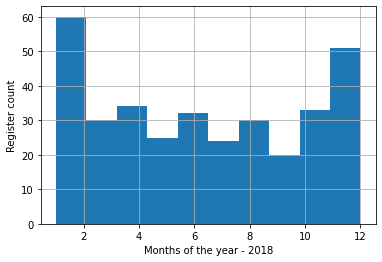

In [62]:
reg_month_surf = users_data.query('plan == "surf"')['reg_date']
reg_month_surf = reg_month_surf.dt.month
reg_month_surf.hist()

plt.ylabel('Register count')
plt.xlabel('Months of the year - 2018')

 - El registro de clientes nos indica que hay dos periodos fuertes de incorporación en el 2018. El primero; en los primeros meses del año para decaer a la mita de registros en marzo.
 - Luego se sostiene entre 20 y 30 registros por mes hasta octubre cuando comienza a aumentar hasta poco más de los 50 registros en diciembre.

Esto nos indica claramente que ya existían bastantes clientes registrados antes de junio; por lo tanto, las medias de llamadas de tiempo 0 minutos nos pueden indicar dos cosas:
 - Gran parte de los clientes simplemente no realizaba llamadas antes de junio.
 - El plan Surf en un comienzo no incluía los minutos en llamadas por lo que la gente evitaba los cobros extras.
 - El plan Surf en un comienzo se presentó como un plan casi exclusivamente para datos y mensajes.
 
Todo esto lo iremos confirmando en la medida que descubramos el comportamiento en los otros casos.

#### Llamadas - Minutos (parte 2)

##### Comportamiento de la media y mediana

Text(0.5, 0, 'Time mean')

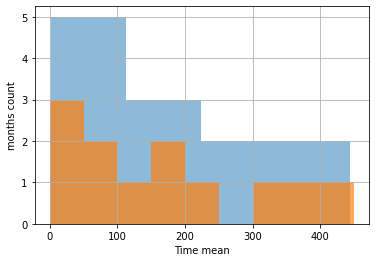

In [63]:
# Generamos un histograma de la media con dos representaciones de los datos
surf_time_stats['mean'].hist(bins=4, alpha=0.5)
surf_time_stats['mean'].hist(bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450], alpha=0.7)

plt.ylabel('months count')
plt.xlabel('Time mean')

A modo general y de acuerdo al histograma dividido en 4 grupos (azul); cuando el tiempo de llamadas va aumentando, la cantidad de meses va disminuyendo.

En el segundo histograma (naranjo) podemos ver una representación más detallada. 
 - Son 5 meses claramente los que tienen menos de 100 minutos en llamadas.
 - Hay 2 meses que tienen entre 150 y 200 minutos en llamadas. Los datos restantes corresponden solo a un mes.
 - Existe un tramo de minutos que no es la media para ni un mes; 250 a 300 minutos.
 
Vamos a analizar ahora la media respecto de la mediana:

In [64]:
# Creamos una variable para asignar los números para cada mes
month_number = [ i for i in range(1,13)]

# Agregamos una columna con los meses para facilitar el gráfico
surf_time_stats.insert(0, 'month', month_number) 

Text(12, 500, 'minutes limit')

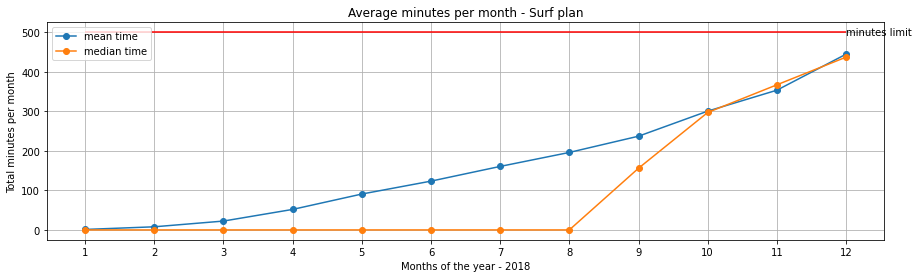

In [65]:
# Generamos el gráfico
surf_time_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean time', 'median time'], 
                     style='-o', 
                     title= 'Average minutes per month - Surf plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total minutes per month')
plt.xlabel('Months of the year - 2018')

# Mostramos el rango de los 12 valores en el eje x
plt.xticks([i for i in range(13)])

# Trazamos una línea en el límite de minutos del plan Surf (500 minutos)
plt.hlines(y =[500], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 500, 'minutes limit', ha='left', va='center')

- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva. 
- Desde octubre hasta diciembre son bastante simétricas. 
- La mediana representa de mejor forma los datos debido a la presencia de valores atípicos.
- La media ni mediana sobrepasan el valor límite de tiempo de llamadas.

##### Diagrama de caja para los minutos totales

Utilizaremos el diagrama de cajas para ver la distribución de cuartiles y confirmar el sesgo de los datos. También nos ayudará a visualizar si hay alguna porción de datos que sobrepasa el límite de minutos.

Text(0.5, 0, 'Months of the year - 2018')

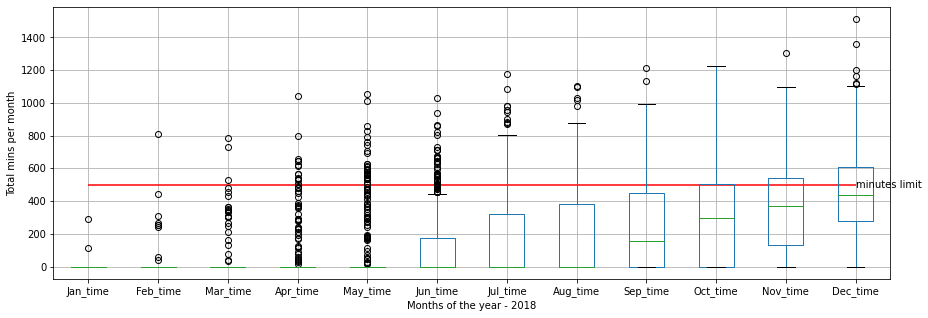

In [66]:
# Creamos los diagramas de cajas
megaline_surf_times.boxplot(grid=True, figsize=(15,5))

# Trazamos una línea en el límite de minutos del plan Surf (500 minutos)
plt.hlines(y =[500], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 500, 'minutes limit', ha='left', va='center')

plt.ylabel('Total mins per month')
plt.xlabel('Months of the year - 2018')

- Las distancias entre el primer cuartil y la mediana es bastante menor a las distancias de la mediana con el tercer cuartil, es decir tienen un sesgo positivo (asimetría positiva).
- La distribución de los tiempos está fuertemente sesgada hacia la derecha (cajas vistass de forma horizontal), esto confirma lo anterior, la media será mayor a la mediana.
- Desde octubre tenemos que al menos un 25% de los datos (tercer cuartil) sobrepasa el límite de minutos del plan (500 minutos). Para diciembre este límite se acerca a la media.

#### Tráfico web - gigabytes

##### Estadísticas de tráfico web mensual

Repetimos lo aplicado en las llamadas para obtener las estadísticas mensuales para el tráfico web.

In [67]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
surf_gigabytes_stats = megaline_surf_gigabytes.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
surf_gigabytes_stats = surf_gigabytes_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_gigabytes_surf = megaline_surf_gigabytes.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
surf_gigabytes_stats.insert(2, 'var', variance_gigabytes_surf) 

# Mostramos nuestra tabla final
surf_gigabytes_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_gb,339.0,0.029499,0.200311,0.447561,0.0,0.0,0.0,0.0,8.0
Feb_gb,339.0,0.324484,4.852979,2.202948,0.0,0.0,0.0,0.0,20.0
Mar_gb,339.0,0.920354,15.836833,3.979552,0.0,0.0,0.0,0.0,30.0
Apr_gb,339.0,1.802360,26.981533,5.194375,0.0,0.0,0.0,0.0,28.0
May_gb,339.0,3.206490,48.170254,6.940479,0.0,0.0,0.0,0.0,36.0
Jun_gb,339.0,4.430678,62.683790,7.917310,0.0,0.0,0.0,7.5,37.0
Jul_gb,339.0,6.023599,87.389974,9.348260,0.0,0.0,0.0,14.0,39.0
Aug_gb,339.0,8.067847,105.347454,10.263891,0.0,0.0,0.0,17.0,51.0
Sep_gb,339.0,9.545723,96.355152,9.816066,0.0,0.0,9.0,18.0,37.0
Oct_gb,339.0,12.165192,106.268489,10.308661,0.0,0.0,13.0,20.0,46.0


**De la información obtenida del tráfico web mensual podemos hacer ciertas apreciaciones preliminares:**
 
 - La media aumenta de forma regular con el pasar de los meses. A partir de abril la media sobrepasa 1 gigabyte y comienza a aumentar de forma lineal hasta 17 gigabytes en diciembre donde sobrepasa el límite (15 gb).
 
 - La varianza va en aumento pero tiende a tener bajas desde septiembre. A partir de este mes la distancia de los datos a la media tiende a regularse.
 
 - La desviación estándar va en aumento hasta julio y después se mantiene relativamente estable.
 
 - La mediana solo presenta valores mayores a 0 desde septiembre. Desde septiembre a diciembre sus valores son similares a la media.
 
 
 - De acuerdo a los cuartiles observados, tenemos que:
    -  De enero a mayo, casi la totalidad de los datos presenta ausencia de uso de datos web (al igual que con las llamadas).
    -  Desde junio a agosto podemos ver incorporación de datos que solo alcanza el tercer cuartil (solo el 25% de la totalidad de clientes). **El mismo comportamiento se puede ver en las llamadas**
    -  Desde septiembre a octubre podemos apreciar la incorporación de más uso de datos, alcanzando por primera vez una mediana distinta de 0. **El mismo comportamiento se puede ver en las llamadas**
    - Para los meses finales de noviembre y diciembre ya podemos apreciar que todos los cuartiles tienen presencia de uso de gigabytes.
    
**El comportamiento de los clientes es muy similar al caso de las llamadas; los periodos de uso son prácticamente los mismos. Y de acuerdo a los registros de clientes para el plan, tenemos un registro simétrico para gran parte de los meses. 
Por lo tanto, la suposición que nos queda es que la mayoría de datos han estado siendo recopilados solo a partir de junio aproximadamente de una forma progresiva (más clientes con el pasar de los meses)**

##### Comportamiento de la media y la mediana 

Text(0.5, 0, 'Gigabytes mean')

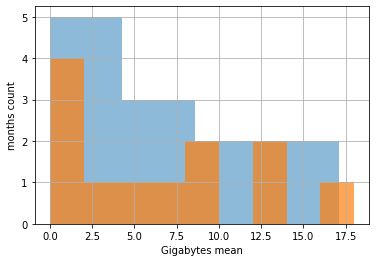

In [68]:
# Generamos un histograma de la media con dos representaciones de los datos
surf_gigabytes_stats['mean'].hist(bins=4, alpha=0.5)
surf_gigabytes_stats['mean'].hist(bins=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], alpha=0.7)

plt.ylabel('months count')
plt.xlabel('Gigabytes mean')

A modo general y de acuerdo al histograma dividido en 4 grupos (azul); cuando la cantidad de gigabytes usados va aumentando, la cantidad de meses va disminuyendo.

La distribución de gigabytes de acuerdo a cantidad de meses es pareja dejando de lado 4 meses en que los valores medios son menores a 3gb y que existe una media de mes alejada de los demás en la que se superan los gigabytes límite (15gb).
 
Vamos a analizar ahora la media respecto de la mediana:

In [69]:
# Agregamos una columna con los meses para facilitar el gráfico
surf_gigabytes_stats.insert(0, 'month', month_number) 

Text(12, 15, 'gigabytes limit')

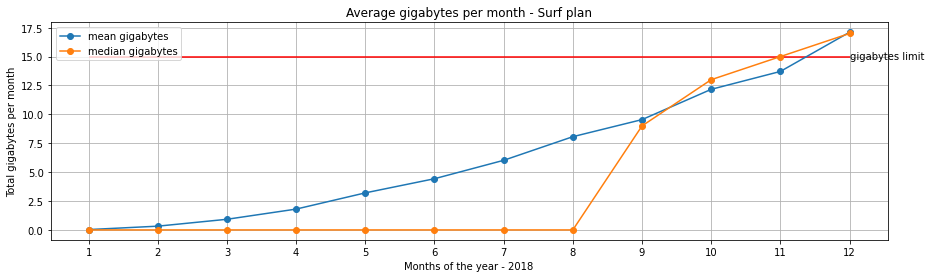

In [70]:
# Generamos el gráfico
surf_gigabytes_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean gigabytes', 'median gigabytes'], 
                     style='-o', 
                     title= 'Average gigabytes per month - Surf plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total gigabytes per month')
plt.xlabel('Months of the year - 2018')

# Mostramos el rango de los 12 valores en el eje x
plt.xticks([i for i in range(13)])

# Trazamos una línea en el límite de gigabytes del plan Surf (15gb)
plt.hlines(y =[15], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 15, 'gigabytes limit', ha='left', va='center')

- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva. 
- Desde septiembre hasta diciembre son bastante simétricas. 
- La mediana representa de mejor forma los datos debido a la presencia de valores atípicos.
- Gracias a la representación lineal de la mediana, podemos observar que con mayor exactitud serían dos meses los que podrían superar el límite de datos: noviembre y diciembre.

##### Diagramas de caja para los gigabytes mensuales

Text(0.5, 0, 'Months of the year - 2018')

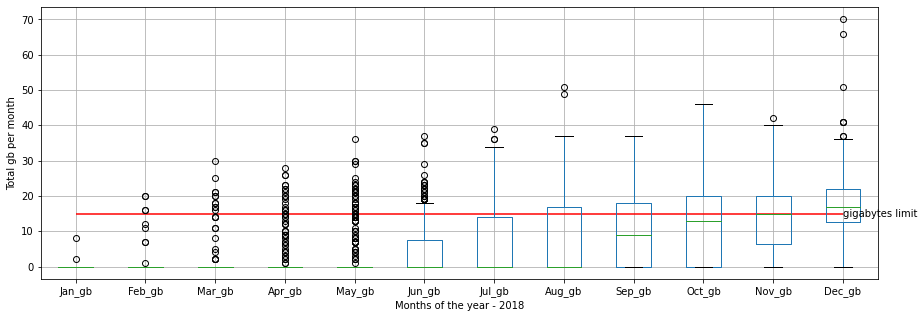

In [71]:
# Creamos los diagramas de cajas
megaline_surf_gigabytes.boxplot(grid=True, figsize=(15,5))

# Trazamos una línea en el límite de minutos del plan Surf (500 minutos)
plt.hlines(y =[15], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 15, 'gigabytes limit', ha='left', va='center')

plt.ylabel('Total gb per month')
plt.xlabel('Months of the year - 2018')

- Las distancias entre el primer cuartil y la mediana es bastante menor a las distancias de la mediana con el tercer cuartil, salvo para el mes de diciembre en el cual la distibución de datos es equitativa aparentemente.
- Desde junio podemos ver que al menos en parte del tercer cuartil, el límite de gigabytes (15) ha sido superado. En julio ya podemos ver como ya casi el tercer cuartil por completo tiene valores que superan el límite. Desde noviembre ya la mitad de datos sobrepasa el límite de gigabytes establecidos en el plan.

#### Mensajería - cantidad de mensajes

##### Estadísticas de mensajería mensual

Repetimos una vez más el procedimiento para finalizar con las estadísticas del plan Surf.

In [72]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
surf_messages_stats = megaline_surf_messages.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
surf_messages_stats = surf_messages_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_messages_surf = megaline_surf_messages.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
surf_messages_stats.insert(2, 'var', variance_messages_surf) 

# Mostramos nuestra tabla final
surf_messages_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_sms,339.0,0.061947,1.300885,1.140563,0.0,0.0,0.0,0.0,21.0
Feb_sms,339.0,0.318584,12.868618,3.587286,0.0,0.0,0.0,0.0,58.0
Mar_sms,339.0,1.035398,37.330104,6.109837,0.0,0.0,0.0,0.0,59.0
Apr_sms,339.0,2.566372,110.897209,10.530774,0.0,0.0,0.0,0.0,120.0
May_sms,339.0,5.454277,292.017874,17.088530,0.0,0.0,0.0,0.0,149.0
Jun_sms,339.0,7.238938,390.981201,19.773245,0.0,0.0,0.0,0.0,133.0
Jul_sms,339.0,9.648968,496.252151,22.276718,0.0,0.0,0.0,3.0,164.0
Aug_sms,339.0,13.752212,697.636644,26.412812,0.0,0.0,0.0,19.0,156.0
Sep_sms,339.0,17.604720,805.523765,28.381751,0.0,0.0,0.0,27.5,153.0
Oct_sms,339.0,23.657817,1132.154754,33.647507,0.0,0.0,7.0,37.0,224.0


**De la información obtenida de la mensajería mensual podemos hacer ciertas apreciaciones preliminares:**
 
 - La media aumenta de forma regular con el pasar de los meses. En ningun momento se soprepasa el límite de 500 mensajes. En diciembre llega a su media máxima de 36 (mediana de 27 mensajes).
 
 - La varianza va en aumento de forma regular y tiene un incremento considerable de septiembre a octubre y de noviembre a diciembre. Esto también puede ser indicio de los datos atípicos máximos para estos meses.
 
 - La desviación estándar va en aumento constante salvo una muy leve baja en noviembre.
 
 - La mediana solo presenta valores mayores a 0 desde octubre. 
 
 - Los valores de medias y medianas son bastante distantes entre si; al parecer debido a una gran presencia de valores atípicos.
 
 
 - De acuerdo a los cuartiles observados, tenemos que:
    -  De enero a junio, casi la totalidad de los datos presenta ausencia de uso de mensajes(un mes más de inactividad respecto a las llamadas y datos web).
    -  Desde julio a septiembre podemos ver incorporación de mensajes que solo alcanza el tercer cuartil (solo el 25% de la totalidad de clientes). **Se mantiene la proporción del desfase respecto a llamads y datos web.**
    -  En octubre y noviembre podemos apreciar la incorporación de más uso de mensajes hasta alcanzar la mitad de clientes del plan Surf.
    
    - Para diciembre ya podemos apreciar que todos los cuartiles tienen presencia de uso de mensajes; sin embargo, el primer cuartil nos presenta un valor continuo (0.5), por lo tanto, hay prácticamente un 25% de clientes que no envían mensajes.
    
**Para la mensajería tenemos un comportamiento levemente distinto que con las llamadas y gigabytes. Solo vemos un inicio de actividad con los mensajes desde julio y desde ahí presenta un patrón similar a las llamadas y tráfico web, manteniendo este mes de diferencia. Debemos destacar que finalmente hay al menos un 25% de clientes que no emiten mensajes según lo observado.

##### Comportamiento de la media y mediana

Text(0.5, 0, 'Messages mean')

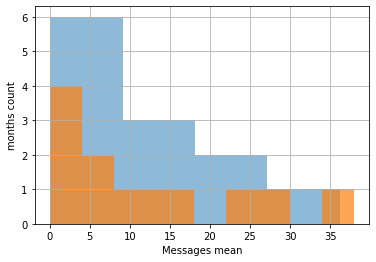

In [73]:
# Generamos un histograma de la media con dos representaciones de los datos
surf_messages_stats['mean'].hist(bins=4, alpha=0.5)
surf_messages_stats['mean'].hist(bins=[0, 4, 8, 12, 16, 18, 22, 26, 30, 34, 38], alpha=0.7)

plt.ylabel('months count')
plt.xlabel('Messages mean')

- La distribución de datos es muy similar a la de las llamadas y tráfico web. Observamos que hay meses con valores bajos y finalmente solo se nos presenta un mes aislado con valores más altos.
- Debemos destacar que también existen dos tramos de datos inexistentes; aproximadamente no hay medias entre 18 y 22 mensajes ni entre 30 y 34 mensajes.
- El grueso de datos se concentra bajo la media de 18 mensajes aproximadamente.




**Analizaremos la media y mediana en conjunto:**

In [74]:
# Agregamos una columna con los meses para facilitar el gráfico
surf_messages_stats.insert(0, 'month', month_number) 

Text(12, 50, 'messages limit')

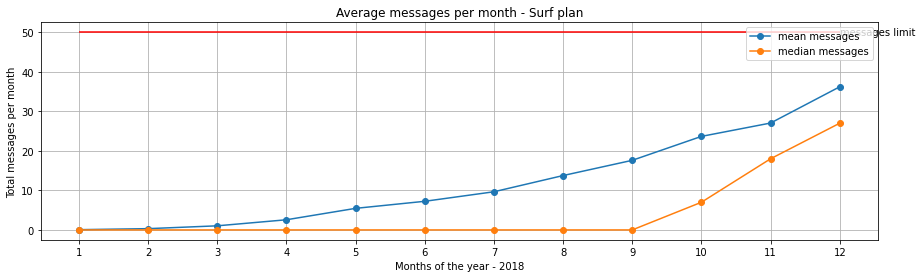

In [75]:
# Generamos el gráfico
surf_messages_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean messages', 'median messages'], 
                     style='-o', 
                     title= 'Average messages per month - Surf plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total messages per month')
plt.xlabel('Months of the year - 2018')

# Mostramos el rango de los 12 valores en el eje x
plt.xticks([i for i in range(13)])

# Trazamos una línea en el límite de mensajes del plan Surf (50 mensajes)
plt.hlines(y =[50], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 50, 'messages limit', ha='left', va='center')

- La media en todo el conjunto es mayor a la mediana, por lo tanto existe una asimetría positiva. 
- En ningún mes se supera el límite de mensajes fijados por el plan.
- Existen diferencias considerables respecto de la media y mediana a partir de abril. Por lo tanto observaremos la influencia de valores atípicos que pueden estar desviando nuestra media.

##### Diagramas de caja para la cantidad de mensajes mensual

Text(0.5, 0, 'Months of the year - 2018')

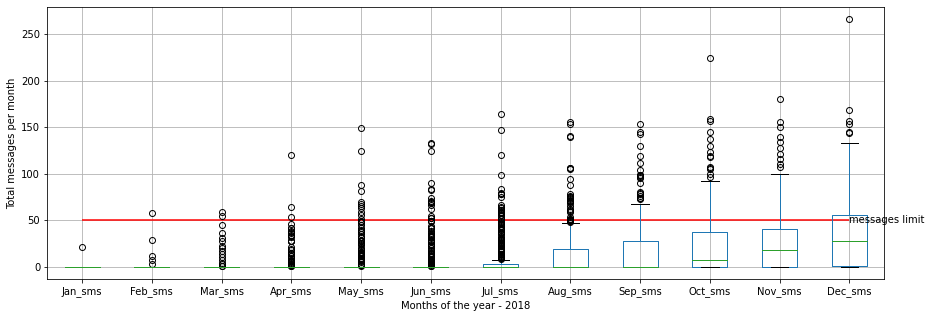

In [76]:
# Creamos los diagramas de cajas
megaline_surf_messages.boxplot(grid=True, figsize=(15,5))

# Trazamos una línea en el límite de mensajes del plan Surf (50 mensajes)
plt.hlines(y =[50], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 50, 'messages limit', ha='left', va='center')

plt.ylabel('Total messages per month')
plt.xlabel('Months of the year - 2018')

Tal como lo habíamos predicho. Existe una fuerte presencia de valores atípicos.

Otras características a considerar:

- La distribución de datos tiene un sesgo considerable hacia la derecha. Ni siquierea en diciembre se refleja una distribución simétrica (como lo ocurrido con las llamadas y tráfico web).
- Tenemos un dato que no pudimos observar con la media y mediana: el límite de mensajes es superado por al menos el 25% de los clientes (tercer cuartil) en diciembre.

#### Conclusiones para el plan Surf

 **A modo general:**
 
 - Tenemos 339 clientes registrados con el plan. Aproximadamente un 70% de los usuarios sujetos al análisis.
 - El dataset muestra una dispersión alta de los datos, la cual se confirma con una varianza que se mantiene en aumento constante solo para estabilizarse hacia los últimos meses para las llamadas y tráfico web.
 - La mediana da valores más acordes al general de clientes.
 - Se analizaron las fechas de registros para intentar dar respuesta a la gran ausencia de datos en los primeros meses. El resultado fue el siguiente:
    - Durante todo el año existen registros con el plan, con alzas importantes a principios y fines de año.
    - Debido a lo anterior, se estima que la ausencia de datos se deba cambios en el plan u datos que fueron siendo recopilados paulatinamente.

**Respecto a medias y medianas:**

- Existen en promedio entre 4 y 5 meses que concentran gran cantidad de datos con cifras bajas; en el caso de las llamadas, menores a 100 minutos, en el caso de los gigabytes, menores a 2.5gb y por último, para los mensajes, menores a 5 mensajes
- Tanto para llamadas, datos y mensajes; existen tramos de valores medios en que su intervalo no refleja la media de ni un mes.
- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva. 
- La mediana representa de mejor forma los datos debido a la presencia de valores atípicos.
- Solo en el caso del tráfico web, la media y mediana sobrepasan el límite mensual (15 gb) en noviembre y diciembre.


**Respecto a los cuartiles:**


 - Las distancias entre el primer cuartil y la mediana por lo general es bastante menor a las distancias de la mediana con el tercer cuartil; por lo tanto, podemos decir que existe un sesgo positivo (asimetría positiva).
 
-  De enero a mayo, casi la totalidad de los datos presenta una fuerte ausencia. Teniendo sus cuartiles acumulados en el valor 0.

-  Desde junio podemos ver incorporación de datos que solo alcanza el tercer cuartil (solo el 25% de la totalidad de clientes).
    
- Desde octubre aproximadamente, tenemos que al menos un 25% de los datos (tercer cuartil) sobrepasa el límite tanto en llamadas como tráfico web. Para diciembre estos límites se acercan a la media, pero en los mensajes, para este mes el límite solo alcanza el tercer cuartil.

- La distribución en los mensajes tiene un mayor sesgo y existe una mayor influencia de valores atípicos.


Es interesante como el comportamiento de los usuarios en llamadas, gigabytes y mensajes es similar. Esto responde no a alguna preferencia que haya variado durante el tiempo respecto a estos servicios, sino que a algo conjunto del plan. Esto puede ser debido a:

 - Cambio de condiciones y tarifas en el plan.
 - Información que fue aclarada con el pasar de los meses.
 - Gran parte de los datos de uso fueron recopilados solo a partir de junio.
 - Otros factores.

Debemos considerar que el comportamiento en cuanto a los mensajes es algo más disperso quizás por la misma naturaleza del servicio, es decir, la desventaja tecnológica frente al tráfico web que puede mermar su uso.

### Clientes de plan Ultimate

Recordamos las características del plan:

  1.	Pago mensual: 70\$
  2.	3000 minutos al mes, 1000 SMS y 30 GB de datos
  3.	Si se exceden los límites del paquete:
        - 1 minuto: 1 centavos
        - 1 SMS: 1 centavos
        - 1 GB de datos: 7$
        
*Nota: Cada llamada individual se redonde al minuto y para tráfico web, el total mensual se aproxima al gigabyte superior.

Repetimos el procedimiento usado para el plan Surf donde filtramos los datos de acuerdo al plan.

In [77]:
# Repetimos el proceso que realizamos para el plan Surf con los clientes de plan Ultimate
megaline_ultimate_times = megaline_totals.query('plan == "ultimate"')[['Jan_time', 'Feb_time', 'Mar_time',
                                         'Apr_time','May_time','Jun_time',
                                         'Jul_time','Aug_time','Sep_time',
                                         'Oct_time','Nov_time','Dec_time']]

megaline_ultimate_gigabytes = megaline_totals.query('plan == "ultimate"')[['Jan_gb', 'Feb_gb', 'Mar_gb',
                                         'Apr_gb','May_gb','Jun_gb',
                                         'Jul_gb','Aug_gb','Sep_gb',
                                         'Oct_gb','Nov_gb','Dec_gb']]

megaline_ultimate_messages = megaline_totals.query('plan == "ultimate"')[['Jan_sms', 'Feb_sms', 'Mar_sms',
                                         'Apr_sms','May_sms','Jun_sms',
                                         'Jul_sms','Aug_sms','Sep_sms',
                                         'Oct_sms','Nov_sms','Dec_sms']]

Antes de revisar las estadísticas propiamente tal, veremos la distribución de registros de clientes para concluir si existen comportamientos anómalos que puedan afectar nuestras conclusiones futuras.

#### Registros en el plan Ultimate de acuerdo a los meses

Text(0.5, 0, 'Months of the year - 2018')

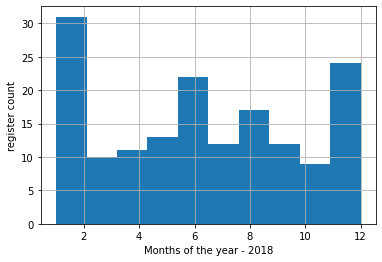

In [78]:
reg_month_ultimate = users_data.query('plan == "ultimate"')['reg_date']
reg_month_ultimate = reg_month_ultimate.dt.month
reg_month_ultimate.hist()

plt.ylabel('register count')
plt.xlabel('Months of the year - 2018')

De acuerdo a los registros por mes, tenemos presencia de registros en plan Ultimate durante todo el año, siendo más alta para principios y finales de año de una forma muy similar a lo que fue con el plan Surf.

Si calculamos la densidad de acuerdo al área de las barras, para Enero y febrero se registraron poco más de 60 personas y para noviembre y diciembre lo hicieron aproximadamente 50 personas en total. Entre estos dos tramos ya tenemos más de la mitad de los clientes Ultimate.

#### Llamadas - Minutos

##### Estadísticas de llamadas mensuales

In [79]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
ultimate_time_stats = megaline_ultimate_times.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
ultimate_time_stats = ultimate_time_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_time_ultimate = megaline_ultimate_times.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
ultimate_time_stats.insert(2, 'var', variance_time_ultimate) 

# Mostramos nuestra tabla final
ultimate_time_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_time,161.0,4.807453,1223.531444,34.979014,0.0,0.0,0.0,0.0,290.0
Feb_time,161.0,17.527950,9684.638276,98.410560,0.0,0.0,0.0,0.0,776.0
Mar_time,161.0,22.677019,10686.607531,103.376049,0.0,0.0,0.0,0.0,711.0
Apr_time,161.0,43.937888,17311.808618,131.574346,0.0,0.0,0.0,0.0,746.0
May_time,161.0,73.173913,32196.357065,179.433434,0.0,0.0,0.0,0.0,863.0
Jun_time,161.0,108.291925,40842.107997,202.094305,0.0,0.0,0.0,118.0,797.0
Jul_time,161.0,156.503106,68913.089053,262.513026,0.0,0.0,0.0,304.0,1188.0
Aug_time,161.0,185.850932,67527.377640,259.860304,0.0,0.0,0.0,373.0,1292.0
Sep_time,161.0,233.701863,78247.098059,279.726828,0.0,0.0,159.0,441.0,1232.0
Oct_time,161.0,296.757764,81589.159705,285.638162,0.0,0.0,271.0,512.0,1215.0


**De la información obtenida de las llamadas podemos hacer ciertas apreciaciones preliminares:**
 
 - Para el plan Ultimate contamos con 161 clientes, esto es poco más del 30% de los clientes totales.
 
 - La media aumenta de forma regular con el pasar de los meses. Comienza en enero con una media de casi 5 minutos al mes por cliente y termina en una media de 430 minutos aproximadamente al mes por cliente.
 
 - La mediana, que debido a lo disperso de los datos debería ser una medida más acorde a la realidad; solo es mayor a 0 a partir del mes de septiembre, llegando a diciembre con una mediana muy parecida a la media.
 
 - La varianza va en aumento constante y solo empieza a decaer en noviembre. La dispersión de los datos respecto a la media es considerable.
 
 
 - De acuerdo a los cuartiles observados, tenemos que:
    -  De enero a mayo, casi la totalidad de los datos presenta ausencia de llamadas, al igual que con los clientes del plan Surf.
    -  Y de la misma forma que en Surf:
       - Desde junio a agosto podemos ver incorporación de datos que solo alcanza el tercer cuartil (solo el 25% de la totalidad de clientes).
       - Desde septiembre a octubre podemos apreciar la incorporación de más llamadas, alcanzando por primera vez una mediana distinta de 0.
       - Para los meses finales de noviembre y diciembre ya podemos apreciar que todos los cuartiles tienen presencia de minutos.
    
**El comportamiento de los datos es bastante similar al plan analizado anteriormente, por lo que reafirmamos algunas teorías:**
1. Cambios en las condiciones de servicio de los planes.
2. En un comienzo se recopilaron datos de uso de pocos clientes pero desde junio esto aumentó considerablemente.

Consideramos que este último punto puede ser el más exacto de acuerdo a todo lo analizado hasta el momento.

##### Comportamiento de la media y mediana 

Text(0.5, 0, 'time in mins mean')

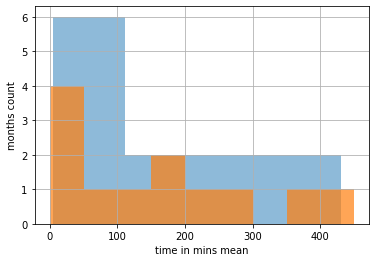

In [80]:
# Generamos un histograma de la media con dos representaciones de los datos
ultimate_time_stats['mean'].hist(bins=4, alpha=0.5)
ultimate_time_stats['mean'].hist(bins=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450], alpha=0.7)

plt.ylabel('months count')
plt.xlabel('time in mins mean')

El histograma azul (dividido en 4 tramos) nos muestra que hay 6 meses que están bajo 100 minutos la media aproximadamente. Entre los otros meses, se repite la cantidad de dos meses para los siguientes tramos de forma proporcional.

En el segundo histograma (naranjo) podemos ver que de esos 6 meses, 4 tienen una media de menos de 50 minutos. Además, 6 meses mantienen una media distinta entre si; y los dos restantes, están en el intervalo de 150 a 200 minutos aproximadamente.
 
Vamos a analizar ahora la media respecto de la mediana:

In [81]:
# Agregamos una columna con los meses para facilitar el gráfico
ultimate_time_stats.insert(0, 'month', month_number)

Text(12, 3000, 'minutes limit')

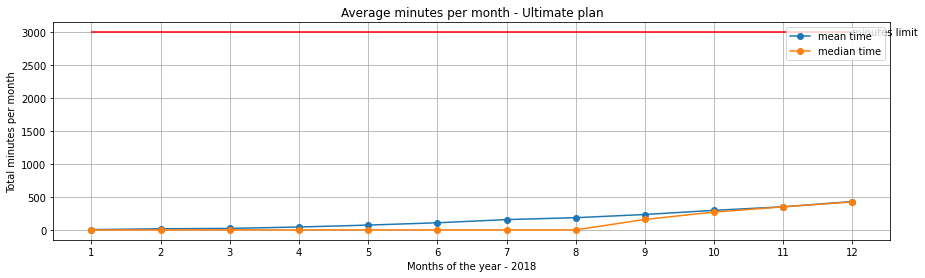

In [82]:
# Generamos el gráfico
ultimate_time_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean time', 'median time'], 
                     style='-o', 
                     title= 'Average minutes per month - Ultimate plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total minutes per month')
plt.xlabel('Months of the year - 2018')

# Mostramos el rango de los 12 valores en el eje x
plt.xticks([i for i in range(13)])

# Trazamos una línea en el límite de minutos del plan Ultimate (3000 minutos)
plt.hlines(y =[3000], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 3000, 'minutes limit', ha='left', va='center')

- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva. 
- Desde octubre hasta diciembre son bastante simétricas. 
- La media y mediana están muy lejos del valor límite establecido por el plan.

**El comportamiento de la media y mediana en las llamadas en el plan Ultimate, es similar al del plan Surf.**

##### Diagrama de caja para los minutos totales

Utilizaremos el diagrama de cajas para ver la distribución de cuartiles y confirmar el sesgo de los datos. También nos ayudará a visualizar si hay alguna porción de datos que sobrepasa el límite de minutos.

Text(0.5, 0, 'Months of the year - 2018')

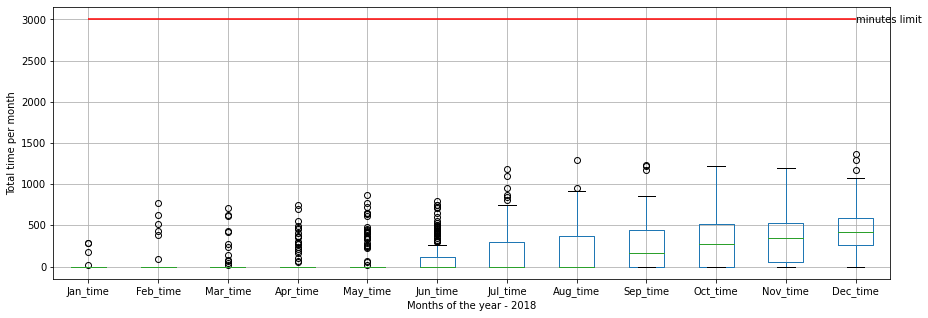

In [83]:
# Creamos los diagramas de cajas
megaline_ultimate_times.boxplot(grid=True, figsize=(15,5))

# Trazamos una línea en el límite de minutos del plan Ultimate (3000 minutos)
plt.hlines(y =[3000], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 3000, 'minutes limit', ha='left', va='center')

plt.ylabel('Total time per month')
plt.xlabel('Months of the year - 2018')

- Se rafirma la asimetría positiva vista con la media y mediana. La distancia entre el primer cuartil y mediana es mucho menor a la distancia entre mediana y tercer cuartil.

- En ningún caso se sobrepasa el límite de minutos, ni siquiera en los valores atípicos.
- La distribución de datos más pareja se puede apreciar en diciembre, al igual que con las llamadas en el plan Surf.

#### Tráfico web - gigabytes

##### Estadísticas de tráfico web mensual

In [84]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
ultimate_gigabytes_stats = megaline_ultimate_gigabytes.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
ultimate_gigabytes_stats = ultimate_gigabytes_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_gigabytes_ultimate = megaline_ultimate_gigabytes.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
ultimate_gigabytes_stats.insert(2, 'var', variance_gigabytes_ultimate) 

# Mostramos nuestra tabla final
ultimate_gigabytes_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_gb,161.0,0.180124,1.561102,1.249441,0.0,0.0,0.0,0.0,11.0
Feb_gb,161.0,0.751553,13.925388,3.731674,0.0,0.0,0.0,0.0,22.0
Mar_gb,161.0,1.372671,33.072748,5.750891,0.0,0.0,0.0,0.0,36.0
Apr_gb,161.0,2.130435,41.176630,6.416902,0.0,0.0,0.0,0.0,37.0
May_gb,161.0,3.037267,51.736102,7.192781,0.0,0.0,0.0,0.0,33.0
Jun_gb,161.0,4.503106,69.289053,8.324005,0.0,0.0,0.0,5.0,38.0
Jul_gb,161.0,6.043478,86.829348,9.318227,0.0,0.0,0.0,14.0,38.0
Aug_gb,161.0,7.869565,104.389130,10.217100,0.0,0.0,0.0,16.0,40.0
Sep_gb,161.0,9.086957,97.567391,9.877621,0.0,0.0,8.0,17.0,37.0
Oct_gb,161.0,11.664596,106.874301,10.338003,0.0,0.0,13.0,19.0,46.0


**De la información obtenida del tráfico web mensual podemos hacer ciertas apreciaciones preliminares:**
 
 - La media aumenta de forma regular con el pasar de los meses. A partir de marzo sobrepasa 1 gigabyte para terminar en diciembre con 17 gigabytes de media aproximadamente.
 
 - La varianza va en aumento hasta el mes de septiembre donde tiene un descenso, para luego subir en octubre y volver a bajar en el mes de noviembre y diciembre. 
 
 - Tanto la varianza como la desviación estándar nos indican que la variación de los datos cada vez es mayor respecto de la media, pero que de noviembre a diciembre tiene una baja considerable lo que representa que su media será más fiel a la realidad de los usuarios (esto también lo confirma el valor de la mediana igual al de la media para diciembre).
 
 - La mediana solo presenta valores mayores a 0 desde septiembre. Presenta el mismo comportamiento que el plan Surf.
 
 
 - De acuerdo a los cuartiles observados, tenemos que se repite el mismo comportamiento que en las llamadas y que en el plan Surf:
    -  De enero a mayo solo contamos con valores atípicos.
    -  Desde junio a agosto podemos ver incorporación de datos que solo alcanzan el tercer cuartil.
    -  Desde septiembre a octubre la mediana alcanza valores distintos a 0.
    - Para noviembre y diciembre ya podemos apreciar que todos los cuartiles tienen presencia de uso de gigabytes.
    

##### Comportamiento de la media y la mediana

Text(0.5, 0, 'gb means')

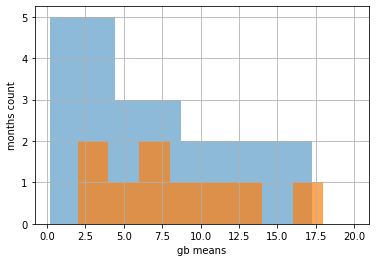

In [85]:
ultimate_gigabytes_stats['mean'].hist(bins=4, alpha=0.5)
ultimate_gigabytes_stats['mean'].hist(bins=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20], alpha=0.7)
plt.ylabel('months count')
plt.xlabel('gb means')

De acuerdo al histograma dividido en cuatro tramos (azul):
- 5 meses con medias de uso entre 0 y 5gb aprox.
- 3 meses con medias de uso entre 5 y 8gb aprox.
- 2 meses con medias de uso entre 8 y 13gb aprox.
- 2 meses con medias de uso entre 13 y 17gb aprox.

La distribución de gigabytes que podemos ver en el gráfico naranja nos describe más detalles:
- No hay meses donde la media sea menor a 2gb aprox.
- Las medias que más se repiten están en los tramos de 2 a 4gb y de 6 a 8gb aprox.
- Existe un tramo de medias que no representa ni un mes: 14 a 16gb aprox.
 
Vamos a analizar ahora la media respecto de la mediana:

In [86]:
# Agregamos una columna con los meses para facilitar el gráfico
ultimate_gigabytes_stats.insert(0, 'month', month_number)

Text(12, 30, 'minutes limit')

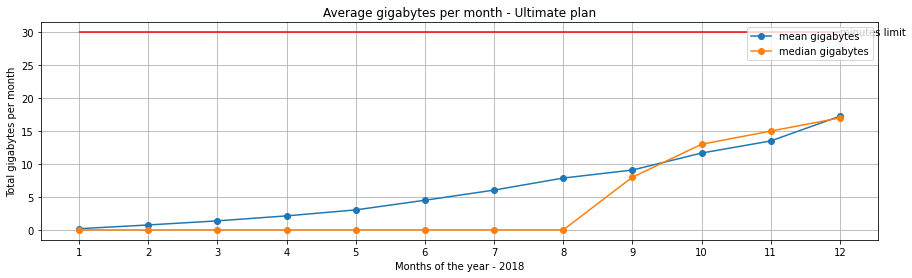

In [87]:
# Generamos el gráfico
ultimate_gigabytes_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean gigabytes', 'median gigabytes'], 
                     style='-o', 
                     title= 'Average gigabytes per month - Ultimate plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total gigabytes per month')
plt.xlabel('Months of the year - 2018')

# Mostramos el rango de los 12 valores en el eje x
plt.xticks([i for i in range(13)])

# Trazamos una línea en el límite de gigabytes del plan Ultimate (30 gigabytes)
plt.hlines(y =[30], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 30, 'minutes limit', ha='left', va='center')

- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva, exceptuando desde octubre en adelante en que la mediana supera a la media, para finalmente igualar practicamente en diciembre. 

- De acuerdo a la media y mediana, se ve bastante distante la superación del límite de gigabytes; se tendría que doblar la media o mediana del mes de diciembre para superar los 30gb límite.

##### Diagramas de caja para los gigabytes totales

Text(0.5, 0, 'Months of the year - 2018')

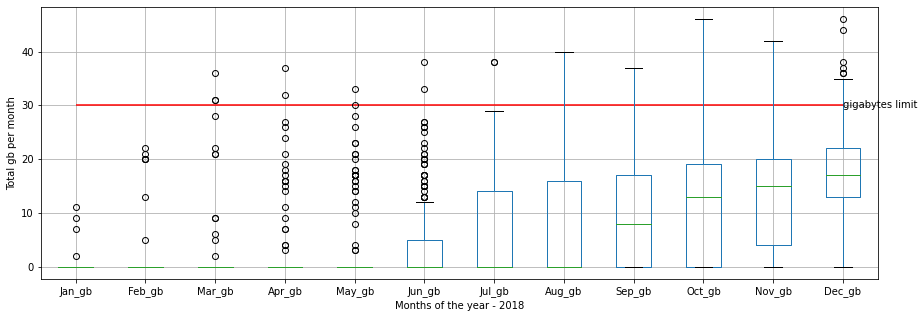

In [88]:
# Creamos los diagramas de cajas
megaline_ultimate_gigabytes.boxplot(grid=True, figsize=(15,5))

# Trazamos una línea en el límite de gigabytes del plan Ultimate (30gb)
plt.hlines(y =[30], xmin= 1, xmax= 12, color = 'r')

# Etiquetamos la línea del límite
plt.text(12, 30, 'gigabytes limit', ha='left', va='center')

plt.ylabel('Total gb per month')
plt.xlabel('Months of the year - 2018')

- Se reafirma la asimetría positiva vista con la media y mediana. La distancia entre el primer cuartil y mediana es mucho menor a la distancia entre mediana y tercer cuartil.

- El límite de gb es superado por cierta fracción del tercer cuartil desde el mes de agosto en adelante. El límite lo sobrepasan menos del 15% de los clientes aproximadamente.

- La distribución de datos más pareja se aprecia en diciembre, al igual que todas las gráficas previamente vistas.

#### Mensajería - cantidad de mensajes

##### Estadísticas de mensajería mensual

In [89]:
# Creamos un dataframe utilizando el método describe para obtener valores estadísticos
ultimate_messages_stats = megaline_ultimate_messages.describe()

# Cambiamos las columnas con los índices para tener un mes por cada fila
ultimate_messages_stats = ultimate_messages_stats.transpose()

# Creamos una variable que contiene las varianzas para cada mes
variance_messages_ultimate = megaline_ultimate_messages.var()

# Insertamos una columna con los datos de las varianzas en la posición 3
ultimate_messages_stats.insert(2, 'var', variance_messages_ultimate) 

# Mostramos nuestra tabla final
ultimate_messages_stats

,count,mean,var,std,min,25%,50%,75%,max
Jan_sms,161.0,0.385093,11.738276,3.426117,0.0,0.0,0.0,0.0,37.0
Feb_sms,161.0,0.937888,37.408618,6.116258,0.0,0.0,0.0,0.0,67.0
Mar_sms,161.0,1.509317,73.451475,8.570384,0.0,0.0,0.0,0.0,72.0
Apr_sms,161.0,2.875776,123.496972,11.112919,0.0,0.0,0.0,0.0,77.0
May_sms,161.0,5.782609,380.183696,19.498300,0.0,0.0,0.0,0.0,149.0
Jun_sms,161.0,8.565217,425.622283,20.630615,0.0,0.0,0.0,0.0,143.0
Jul_sms,161.0,12.031056,599.980280,24.494495,0.0,0.0,0.0,12.0,149.0
Aug_sms,161.0,16.968944,890.692780,29.844477,0.0,0.0,0.0,23.0,151.0
Sep_sms,161.0,20.242236,917.872205,30.296406,0.0,0.0,0.0,35.0,155.0
Oct_sms,161.0,25.968944,1153.455280,33.962557,0.0,0.0,8.0,43.0,153.0


**De la información obtenida de la mensajería mensual podemos hacer ciertas apreciaciones preliminares:**
 
 - La media aumenta de forma regular con el pasar de los meses. En ningun momento se soprepasa el límite de 1000 mensajes. En diciembre llega a su media máxima de 42 mensajes aprox. (mediana de 35 mensajes).
 
 - La varianza y desviación estándar van en aumento regular y en ningún momento se sostienen bajas como en llamadas o gigabytes.
 
 - La mediana solo presenta valores mayores a 0 desde octubre, al igual que con el plan Surf
 
 - Los valores de medias y medianas son bastante distantes entre si; al parecer debido a una gran presencia de valores atípicos. Tal como lo ocurrido en el plan Surf.
 
 
 - De acuerdo a los cuartiles observados, tenemos que el comportamiento del plan Ultimate es muy similar al del plan Surf, salvo por un detalle en el mes de diciembre:
 
    -  De enero a junio solo hay presencia de valores atípicos (un mes más de inactividad respecto a las llamadas y datos web).
    -  Desde julio a septiembre podemos ver incorporación de mensajes que solo alcanza el tercer cuartil.
    -  En octubre y noviembre podemos apreciar la incorporación de más uso de mensajes hasta alcanzar la mitad de clientes.
    
    - Para diciembre ya podemos apreciar que todos los cuartiles tienen presencia de uso de mensajes. A diferencia del plan Surf, donde al menos un 25% de clientes no los usaba.
    

##### Comportamiento de la media y mediana

Text(0.5, 0, 'Messages mean')

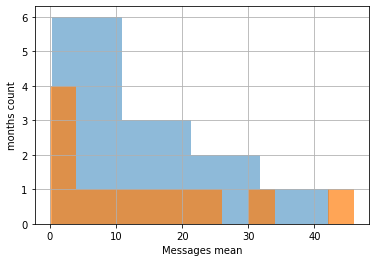

In [90]:
# Generamos un histograma de la media con dos representaciones de los datos
ultimate_messages_stats['mean'].hist(bins=4, alpha=0.5)
ultimate_messages_stats['mean'].hist(bins=[0, 4, 8, 12, 16, 18, 22, 26, 30, 34, 38, 42, 46], alpha=0.7)

plt.ylabel('months count')
plt.xlabel('Messages mean')

De acuerdo al histograma dividido en cuatro tramos (azul):
- 6 meses con medias de cantidad de mensajes entre 0 y 10 aprox.
- 3 meses con medias de cantidad de mensajes entre 10 y 21 aprox.
- 2 meses con medias de cantidad de mensajes entre 21 y 32 aprox.
- 1 mesd con media de cantidad de mensajes entre 32 y 42 aprox.

La distribución de mensajes que podemos ver en el gráfico naranja nos describe más detalles:
- Hay 4 meses donde el uso de mensajes medio es mínimo.
- Existen dos tramos de medias que no representan ni un mes: 26 a 30 y 34 a 41 mensajes aprox.
 


**Analizaremos la media y mediana en sin considerar el valor límite, ya que de acuerdo a los máximos observados, en ninún caso se superan los 1000 mensajes:**

In [91]:
# Agregamos una columna con los meses para facilitar el gráfico
ultimate_messages_stats.insert(0, 'month', month_number)

Text(0.5, 0, 'Months of the year - 2018')

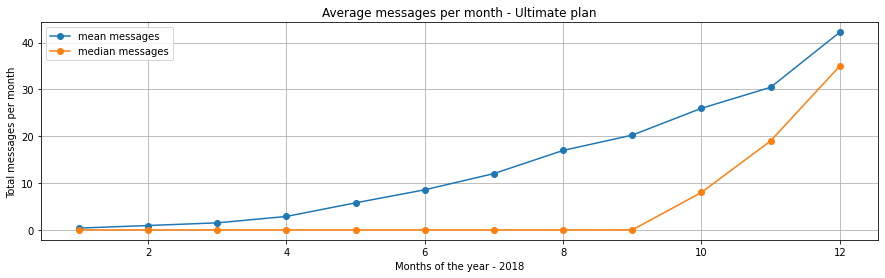

In [92]:
# Generamos el gráfico
ultimate_messages_stats.plot(x= 'month',
                     y=['mean', '50%'], 
                     label=['mean messages', 'median messages'], 
                     style='-o', 
                     title= 'Average messages per month - Ultimate plan', 
                     grid= True, 
                     figsize=(15,4))

plt.ylabel('Total messages per month')
plt.xlabel('Months of the year - 2018')


- La media en todo el conjunto es mayor a la mediana, por lo tanto existe una asimetría positiva. 
- En ningún mes se supera el límite de mensajes fijados por el plan.
- Al igual que en el plan Surf, existen diferencias considerables respecto de la media y mediana a partir de abril. Por lo tanto observaremos la influencia de valores atípicos que pueden estar desviando nuestra media.

##### Diagramas de caja para la cantidad de mensajes mensual

Text(0.5, 0, 'Months of the year - 2018')

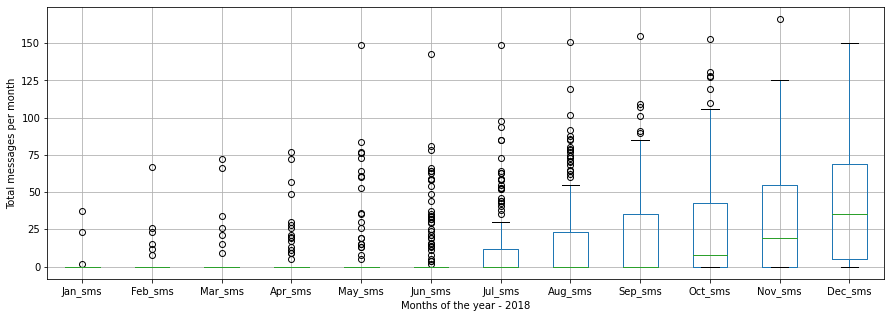

In [93]:
# Creamos los diagramas de cajas
megaline_ultimate_messages.boxplot(grid=True, figsize=(15,5))
plt.ylabel('Total messages per month')
plt.xlabel('Months of the year - 2018')

- Existe una fuerte presencia de valores atípicos.
- La distribución de datos tiene un sesgo considerable hacia la derecha. 
- A diferencia del plan Surf, en ningún momento se supera el límite de mensajes. En el plan Surf lo hizo en diciembre para al menos un 25% de los clientes aprox.

#### Conclusiones para plan Ultimate

 **A modo general:**
 
 - Tenemos 161 clientes registrados con el plan Ultimate. Aproximadamente un 30% de los usuarios sujetos al análisis.
 - Durante todo el año hay presencia de registros en el plan; siendo más alta a principios y finales de año de una forma similar a lo ocurrido en el plan Surf.
 
 - Al igual que con los clientes del plan Surf, el dataset muestra una dispersión alta de los datos, la cual se confirma con una varianza que se mantiene en aumento constante solo para estabilizarse hacia los últimos meses para las llamadas y tráfico web.

- Las similitudes en comportamiento con los clientes del plan Surf, vienen a confirmar la teoría de que los datos fueron recopilados paulatinamente.


**Respecto a medias y medianas:**

- Existen en promedio 5 meses que concentran gran cantidad de datos con cifras bajas; en el caso de las llamadas, menores a 100 minutos, en el caso de los gigabytes, menores a 5gb y por último, para los mensajes, menores a 10 mensajes.

- La media por lo general es mayor a la mediana por lo tanto existe una asimetría positiva. Existe una excepción en el caso de los meses de octubre y noviembre para los gigabytes, donde la mediana supera a la media. De todas formas, se considera a la mediana como mejor representante por la gran presencia de valores atípicos.

- En ningún caso la media ni la mediana se acercan a los límites mensuales asignados.
 
 - La varianza va en aumento constante y solo empieza a decaer en noviembre, por lo tanto, la dispersión de los datos respecto a la media es considerable.


**Respecto a los cuartiles:**


 - Existe una asimetría positiva, al igual que en el plan Surf.
 
-  De enero a mayo, casi la totalidad de los datos presenta una fuerte ausencia de valores.

-  Desde junio podemos ver incorporación de datos de llamadas y tráfico web, que solo alcanzan el tercer cuartil; mientras tanto, en mensajes se logra en julio.
    
- Solo en el tráfico web se ve superado el límite (30gb), pero tan solo para una fracción del tercer cuartil desde agosto hasta diciembre.

- La distribución en los mensajes tiene un mayor sesgo y existe una mayor influencia de valores atípicos, pero también hay un mayor uso que en el plan Surf, ya que hay una mayor distribución a través de todos sus cuartiles.

### Conclusiones finales del análisis de datos

 **Tanto para el plan Surf y el plan Ultimate tenemos patrones que se repiten por lo general:**
 1. Desde enero a mayo solo contamos con valores atípicos.
 2. Desde junio a agosto podemos ver incorporación de datos que solo alcanzan el tercer cuartil.
 3. Desde septiembre a octubre la mediana alcanza valores distintos a 0.
 4. Para noviembre y diciembre ya podemos apreciar una distribución en todos los cuartiles.
 5. En el caso de los mensajes, ocurre un desfase de un mes de este comportamiento, registrando valores en el tercer cuartil desde julio.
 6. El comportamiento en mensajes es más disperso y representa menos uso para gran parte de los clientes posiblemente debido a que el tráfico web se presenta como un reemplazo natural.
 

**Respecto a los límites para cada plan:**
1. Llamadas en Surf (500 minutos):
      - La cantidad de clientes que superan la cifra es relevante y va en aumento desde julio hasta diciembre. Este último mes ya casi la mitad de los usuarios sobrepasan el límite.
      
      
2. Llamadas en Ultimate (3000 minutos):
      - En ningún mes algún usuario supera la cifra, ni siquiera para valores atípicos.
      
      
3. Gigabytes en Surf (15gb):
      - A diferencia de las llamadas, desde junio ya empiezan a superar el límite un número considerable de clientes. En la medida que pasan los meses, más clientes superan el uso; con un resultado final para diciembre donde más del 50% de los clientes han superado el límite.
      
      
4. Gigabytes en Ultimate(30gb):
      - Desde agosto hasta diciembre pasa a ser relevante la cantidad de clientes que superan el límite, aunque siempre se mantiene por debajo del 20% de usuarios.
      
      
5. Mensajes en Surf(50 mensajes):
      - Desde septiembre el límite afecta una porción del tercer cuartil, alcanzando su punto más alto en diciembre donde ya casi el 25% por completo sobrepasa el límite de mensajes.
      
      
5. Mensajes en Ultimate(1000 mensajes):
      - En ningún momento del año existe algún acercamiento al límite, ni siquiera en valores atípicos.    



*- En el plan Surf, al menos 50% de los usuarios llegan a pagar extra por minutos y gigabytes en el rango de los 6 meses finales. Menos del 25% de los usuarios supera el límite de mensajes desde septiembre en adelante.*

*- En el plan Ultimate, el límite solo es superado en la cantidad de gigabytes, pero por menos de 20% de los usuarios y en los periodos de agosto a diciembre.*
 
 
**Si bien los clientes del plan Ultimate pagan una tarifa fija más alta (70), hay más clientes del plan Surf que terminan pagando tarifas extras elevadas hacia fin de año. Recordemos que al menos el 50% de los usuarios sobrepasa el límite de gigabytes, el cual tiene un costo adicional de (10) por unidad; esto representa la mitad del costo del plan (20). También debemos tener en cuenta que los clientes del plan Surf corresponden a un 70% del total.**
 
 
 
**Finalmente, acerca del comportamiento de los datos**
 
Debido a las grandes similitudes, principalmente en el comportamiento de los datos en las llamadas y tráfico web; en un comienzo pensamos que podría ser por estas razones:

 - Fechas de registros de usuarios.
 - Cambio de condiciones y tarifas en el plan.
 - Información que fue aclarada con el pasar de los meses.
 
Pero a través de los distintos análisis, nos dimos cuenta que es muy probable que sea por estas:
 - Gran parte de los datos de uso fueron recopilados solo a partir de junio de forma creciente.
 - Otros factores desconocidos.




## Pruebas de hipótesis

Por las conclusiones planteadas respecto a ambos planes, podemos suponer que las medias de ingresos difieren para los usuarios del plan Surf y plan Ultimate.

Por esto plantearemos nuestra primera hipótesis:
  
  **1. "El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere."**


De acuerdo al registro de usuario en users_data, existe otra característica que nos podría dar una idea de las diferencias en el gasto de los planes, el área de residencia.
Tomaremos como muestra dos locaciones para ver si los ingresos difieren de acuerdo al lugar.

Nuestra segunda hipótesis quedará planteada de la siguiente forma:

   **2. "El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones."**
   

### Primera hipótesis

Procedemos a establecer las medias en variables para el plan Surf y Ultimate:

In [94]:
# Filtramos clientes de acuerdo al plan y pasamos los valores de tarifas mensuales.
surf_monthly_mean = monthly_totals.query(
    'plan == "surf"')[['Jan_total','Feb_total','Mar_total','Apr_total',
                       'May_total','Jun_total','Jul_total','Aug_total',
                       'Sep_total','Oct_total','Nov_total','Dec_total']].mean()

ultimate_monthly_mean = monthly_totals.query(
    'plan == "ultimate"')[['Jan_total','Feb_total','Mar_total','Apr_total',
                           'May_total','Jun_total','Jul_total','Aug_total',
                           'Sep_total','Oct_total','Nov_total','Dec_total']].mean()


#### Prueba de Levene

Realizaremos la prueba de Levene para determinar nuestro valor equal_var a ser utilizado en las pruebas t.

Nuestra hipótesis nula será que las varianzas son iguales.

In [95]:
# Prueba de Levene

plan_levene = st.levene(surf_monthly_mean, ultimate_monthly_mean, center='mean')
plan_levene.pvalue

0.754755975417275

De acuerdo al valor pvalue = 0.75 superior a alpha, no podemos rechazar la hipótesis nula.

Por lo tanto podemos estimar que las varianzas son iguales; por lo tanto, nuestro valor de equal_var se asignará como True.

#### Pruebas t

**Hipótesis:**
*El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere*

Para trabajar en esta hipótesis, usaremos las muestras estratificadas de acuerdo a los planes.

**Nuestra hipótesis nula es:**
 - No hay diferencias en el ingreso promedio de los usuarios de plan Surf y plan Ultimate.

**Por lo tanto, nuestra hipótesis alternativa será:**
 - Hay diferencias en el ingreso promedio de los usuarios de plan Surf y plan Ultimate.

Ya tenemos lista nuestra tabla monthly_totals para comparar las medias mensuales entre el plan Surf y Ultimate.

Antes de eso fijaremos nuestro **umbral para la significación estadística:**

Trabajaremos con un valor de umbral del 5%, esto quiere decir que; un 5% de probabilidad de obtener un resultado como el que consideramos, es demasiado bajo; por esto estamos dispuestos a rechazar la hipótesis nula, no porque sea incorrecto sino porque el valor real resultó estar muy lejos del propuesto.



In [96]:
# Umbral de significación
alpha= 0.05

# Probamos la hipótesis de que las medias de tarifas para cada mes difieren
plan_mean_results = st.ttest_ind(surf_monthly_mean, ultimate_monthly_mean, equal_var=True)

plan_mean_results.pvalue


0.14119465583141402

Si alpha (0.05) es mayor a la probabilidad del resultado, se rechaza la hipótesis nula.
El resultado de la probabilidad es 0.14, por lo tanto nuestro alpha es menor. Es decir, no rechazamos la hipótesis nula.

Existe un 14% de probabilidad de obtener una diferencia del tamaño de las cantidades promedio o mayor. Es una probabilidad alta para concluir que existe una igualdad significativa entre las medias mensuales.

#### Resultado hipótesis

**Nuestra primera hipótesis:** 
*El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.*

**Es rechazada.**

El ingreso entre los usuarios del plan Surf y el plan Ultimate no difiere. Esto se puede confirmar por la prueba de Levene en las que concluímos que las varianzas de los conjuntos son similares.

### Segunda hipótesis

Procedemos a filtrar los clientes del área: New York-Newark-Jersey City, NY-NJ-PA MSA:

In [97]:
# Filtro de las tarifas medias mensuales para la región escogida
ny_nj_monthly_totals = monthly_totals.query(
    'city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')[['Jan_total','Feb_total','Mar_total','Apr_total',
                                                            'May_total','Jun_total','Jul_total','Aug_total',
                                                            'Sep_total','Oct_total','Nov_total','Dec_total']].mean()
# Filtro para las regiones restantes
others_monthly_totals = monthly_totals.query(
    'city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')[['Jan_total','Feb_total','Mar_total','Apr_total',
                                                            'May_total','Jun_total','Jul_total','Aug_total',
                                                            'Sep_total','Oct_total','Nov_total','Dec_total']].mean()


#### Prueba de Levene

Realizaremos la prueba de Levene para determinar nuestro valor equal_var a ser utilizado en las pruebas t.

Nuestra hipótesis nula será que las varianzas son iguales.

In [98]:
# Prueba de Levene

region_levene = st.levene(ny_nj_monthly_totals, others_monthly_totals, center='mean')
region_levene.pvalue

0.8968313350340616

De acuerdo al valor pvalue = 0.89, muy superior a alpha, no podemos rechazar la hipótesis nula.

Por lo tanto podemos estimar que las varianzas son iguales; por lo tanto, nuestro valor de equal_var se asignará como True.

#### Pruebas t

**Hipótesis:** *El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.*

Para trabajar en esta hipótesis, usaremos muestras estratificadas de la siguiente forma:

1. Primera muestra: clientes área de Nueva York-Nueva Jersey.
2. Segunda muestra: clientes de otras regiones.

**Nuestra hipótesis nula es:**
 - No hay diferencias en el ingreso promedio de los usuarios del área de Nueva York-Nueva Jersey al de los usuarios de otras regiones.

**Por lo tanto, nuestra hipótesis alternativa será:**
 - Hay diferencias en el ingreso promedio de los usuarios del área de Nueva York-Nueva Jersey al de los usuarios de otras regiones.

Al igual que en el caso anterior, aplicamos la medida convencional del 5% como umbral de significancia.

In [99]:
# Probamos la hipótesis de que las medias de tarifas para la región escogida difiere de las demás.
region_mean_results = st.ttest_ind(ny_nj_monthly_totals, others_monthly_totals, equal_var=True)
region_mean_results.pvalue

0.8797843064019446

Alpha es muy menor al valor p de 0.87. Por lo tanto, no rechazamos la hipótesis nula.
La diferencia observada es atribuible al azar y existen diferencias en el ingreso promedio.

Aunque las medias mensuales son diferentes, existe un 88% de probabilidad de obtener al azar una diferencia de ese tamaño o mayor.

#### Resultado hipótesis

**Nuestra segunda hipótesis:** 
*El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.*

**Es rechazada.**

No existen mayores diferencias en los ingresos de los usuarios de la región de Nueva York-Nueva Jersey, con los usuarios de otras regiones. Esto se confirma en la prueba de Levene que arrojó como resultado que las varianzas para ambos conjuntos son similares.

## Conclusiones

Trabajamos una muestra estratificada de clientes de Megaline para analizar el servicio de dos tarifas: Surf y Ultimate.

La cantidad de clientes involucrados fueron 500; siendo 339 pertenecientes al plan Surf y 161 al plan Ultimate.

Comenzamos con el preprocesamiento de datos donde resolvimos el tema de los valores ausentes en churn_date. Esta variable hace referencia a la fecha de retiro del plan. Si bien, no era relevante reemplazar sus valores ausentes, para efecto de calcular los periodos de actividad de los usuarios, y teniendo en cuenta que los datos corresponden al año 2018; consideramos una "churn_date" con fecha al 1 de enero del 2019, la cual representa a los clientes que seguían activos a la fecha de recopilación de datos.

Procesamos las fechas, tiempo de llamadas y gigabytes para aplicar cálculos correctos de tarifas.
Además, creamos nuevas columnas y nuevas tablas con información de uso mensual en cada uno de los tres servicios del plan: llamadas, tráfico web y mensajería.

El análisis de datos se dividió en dos partes: para clientes de plan Surf y luego para clientes Ultimate. Las conclusiones respecto a estas fueron muy similares entre si.


 - Descubrimos una fuerte ausencia de datos para la primera mitad de año.
 - Los registros de usuarios fueron de forma proporcional durante todo el año, por lo tanto, la ausencia no se puede atribuir a registros en ciertos meses.
 - Hacia los últimos meses aumenta la presencia de registros alcanzando una distribución normal en todos sus cuartiles.
 - Tanto las llamadas como gigabytes presentan un mayor uso, tanto que para clientes Surf el límite es sobrepasado en estos dos servicios en al menos el 50% de los usuarios para los meses finales.
 - Para clientes de tipo Ultimate, el único limitante fueron los gigabytes incluídos en el plan, ya que al menos el 20% de sus usuarios sobrepasaron el límite los últimos meses del año.

La tarifa fija del plan Ultimate es más alta, pero por lo general presentan menos gastos variables. Esto hace que los clientes de plan Surf puedan incluso llegar a equiparar el gasto de un cliente Ultimate solo por los gastos extras en llamadas o tráfico web.
 
Todo el comportamiento de los datos nos lleva a la siguiente suposición: gran parte de los datos fueron recopilados a partir de junio y de forma paulatina. Esto lo podemos suponer debido a la presencia de registros todo el año, presencia de valores atípicos todos los meses y las similitudes en los periodos de uso de los tres servicios.


Finalmente, debemos aclarar si los ingresos entre los planes son muy distantes, a modo de asignar más recursos de publicidad al plan más rentable; o si existen regiones en la que los usuarios gasten más en los planes.

Las pruebas de hipótesis arrojaron los siguientes resultados:
1. El ingreso recibido por los usuarios del plan Surf y el plan Ultimate no difiere.
2. No existen mayores diferencias en los ingresos recibidos de los usuarios, por ejemplo, de la región de Nueva York-Nueva Jersey, con los usuarios de otras regiones.

La primera hipótesis concuerda con una de las últimas conclusiones: si bien la tarifa fija del plan Ultimate es más alta, existen muchos usuarios del plan Surf que pagan tarifas adicionales y pueden llegar a igualar o superar lo pagado por un cliente Ultimate.

Respecto de la segunda hipótesis, de acuerdo a lo observado durante el análisis de datos, hay pocos determinantes claros que marquen una diferencia en el comportamiento de los usuarios.